## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'cwt-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10) 

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_cwt_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\cwt\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


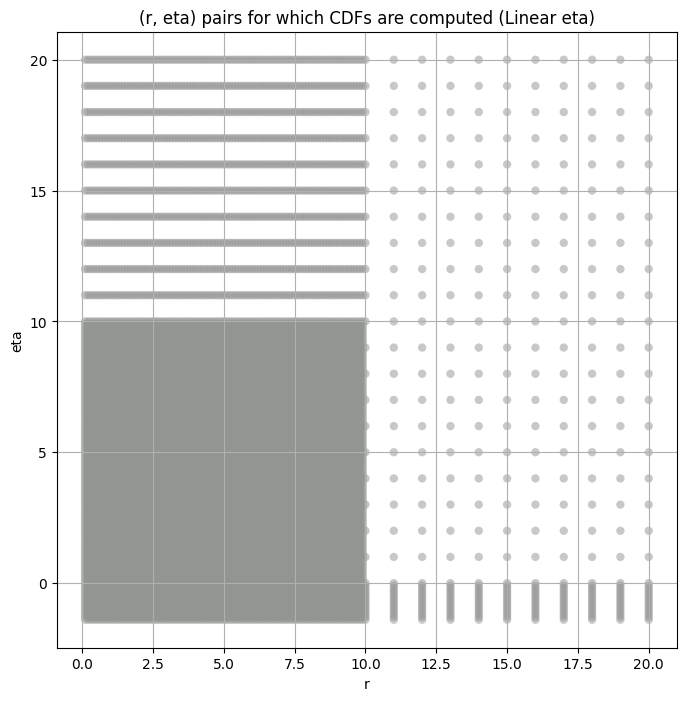

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304350e+08  8.450639e+08  1.021473e+09  11.475002    9.686062   
5     2.319913e+09  2.172740e+09  2.471595e+09   4.323010    3.781578   
8     1.712932e+09  1.609256e+09  1.820339e+09   3.816700    3.299652   
11    1.477210e+09  1.393562e+09  1.562147e+09   2.952862    2.647646   
14    3.512004e+08  3.220831e+08  3.815291e+08   8.838118    7.747682   
18    7.135070e+07  6.541452e+07  7.777086e+07   9.288547    7.105037   
21    2.806441e+07  2.528724e+07  3.112942e+07  14.143866   10.129042   
24    2.347062e+07  2.053493e+07  2.665636e+07  23.600979   19.822874   
27    1.144604e+07  9.863044e+06  1.315475e+07  29.179123   24.510862   
31    3.226470e+05  2.673852e+05  3.902298e+05  51.517807   34.074745   

      kurt_upper  total_samples  
band                             
2      14.108884       100000.0  
5       4.905125       100000.0  
8       4.357325       100000.0  
11      3.273485       100000.0  
14     10.001733       100000.0  
18     12.427702       100000.0  
21     20.413070       100000.0  
24     27.856232       100000.0  
27     34.519924       100000.0  
31    113.403180       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     9.304350e+08   9.304350e+08    9.017852e+08    8.818719e+08   
5     2.319913e+09   2.319913e+09    2.284332e+09    2.254782e+09   
8     1.712932e+09   1.712932e+09    1.687741e+09    1.666046e+09   
11    1.477210e+09   1.477210e+09    1.462489e+09    1.449354e+09   
14    3.512004e+08   3.512004e+08    3.430519e+08    3.362740e+08   
18    7.135070e+07   7.135070e+07    6.894002e+07    6.729108e+07   
21    2.806441e+07   2.806441e+07    2.676407e+07    2.593110e+07   
24    2.347062e+07   2.347062e+07    2.233857e+07    2.146781e+07   
27    1.144604e+07   1.144604e+07    1.082743e+07    1.035036e+07   
31    3.226470e+05   3.226470e+05    2.934222e+05    2.756891e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       8.643890e+08     8.483972e+08     8.194972e+08     7.935224e+08   
5       2.228058e+09     2.203255e+09     2.157845e+09     2.116518e+09   
8       1.646371e+09     1.628277e+09     1.595643e+09     1.566409e+09   
11      1.437032e+09     1.425308e+09     1.403241e+09     1.382593e+09   
14      3.301967e+08     3.246124e+08     3.145245e+08     3.054975e+08   
18      6.591060e+07     6.469983e+07     6.261325e+07     6.083042e+07   
21      2.525373e+07     2.467046e+07     2.368941e+07     2.287366e+07   
24      2.071551e+07     2.004337e+07     1.886958e+07     1.786010e+07   
27      9.938514e+06     9.571533e+06     8.932675e+06     8.385346e+06   
31      2.611019e+05     2.484664e+05     2.273011e+05     2.099719e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        7.697700e+08     7.478188e+08     7.273601e+08     6.730015e+08  
5        2.078248e+09     2.042447e+09     2.008688e+09     1.916930e+09  
8        1.539667e+09     1.514882e+09     1.491635e+09     1.428749e+09  
11       1.363075e+09     1.344497e+09     1.326725e+09     1.277302e+09  
14       2.972602e+08     2.896536e+08     2.825692e+08     2.637236e+08  
18       5.925743e+07     5.784108e+07     5.654888e+07     5.322059e+07  
21       2.216942e+07     2.154687e+07     2.098626e+07     1.955626e+07  
24       1.697116e+07     1.617594e+07     1.545683e+07     1.364194e+07  
27       7.905350e+06     7.477362e+06     7.091438e+06     6.123322e+06  
31       1.952986e+05     1.826030e+05     1.714495e+05     1.445980e+05

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02354084190787853 930435000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.023976354356916363 901785150.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.02469080450335631 881871940.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.025337409103571837 864389000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.02594350882340514 848397250.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.026488575532309655 819497150.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.02586431019471934 793522370.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.026488575532309655 769770050.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.026488575532309655 747818800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.026488575532309655 727360100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.026488575532309655 673001500.0
Number of samples: 100000, Without approximation : 100000.0


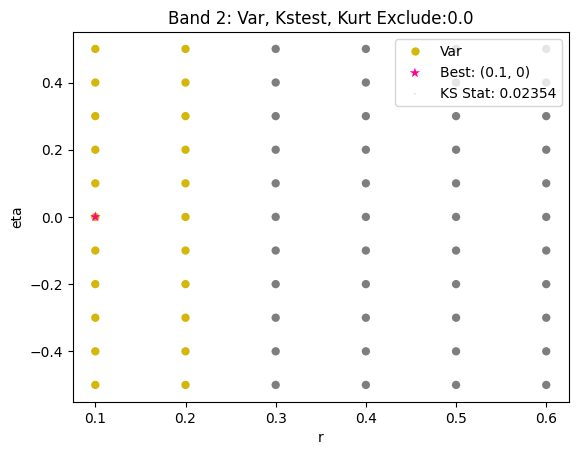

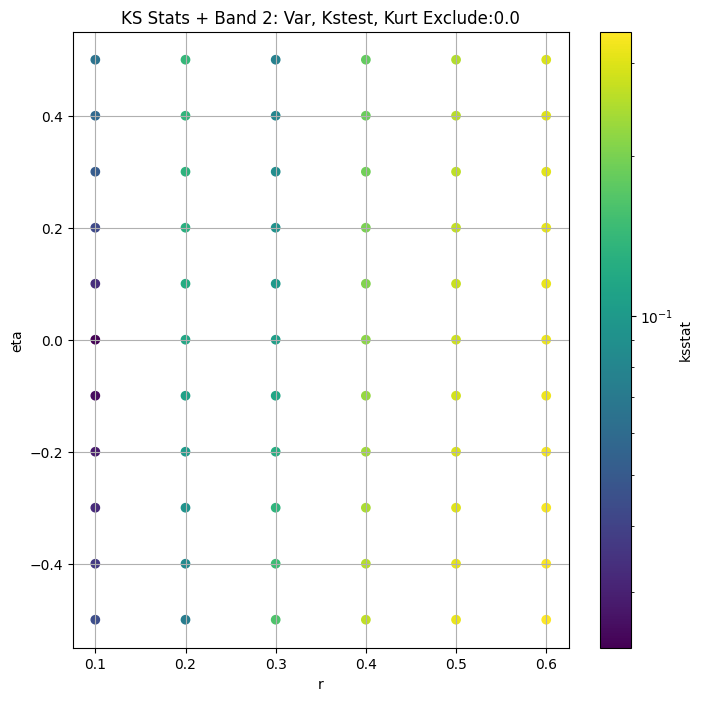

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03269553543994763 2319912700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03223414471300301 2284332300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03238509989983207 2254782200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03312166112757575 2228058400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03381257446773034 2203254500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03504806786443748 2157845200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03445867412030257 2116517500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.03421511763866958 2078247800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03528340180382669 2042447000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.036311632226534885 2008687600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03645398831545532 1916929900.0
Number of samples: 100000, Without approximation : 100000.0


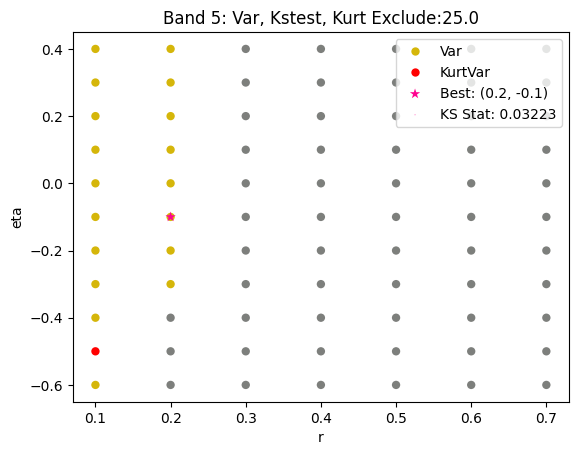

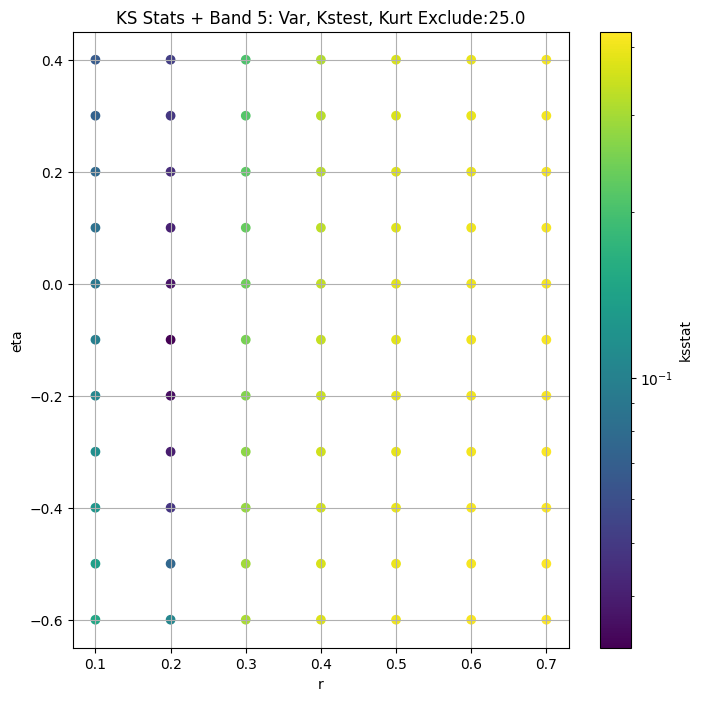

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.023989984588719315 1712932000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.02424455537371828 1687740500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.023857891935401665 1666046500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.024346908734689476 1646371300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.025148701160006517 1628277200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0249601375814113 1595643300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.025719389261084413 1566409100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.026107471252921843 1539667300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.026150120352189096 1514882300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.027212213067806745 1491634700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.027802799053706306 1428749200.0
Number of samples: 100000, Without approximation : 100000.0


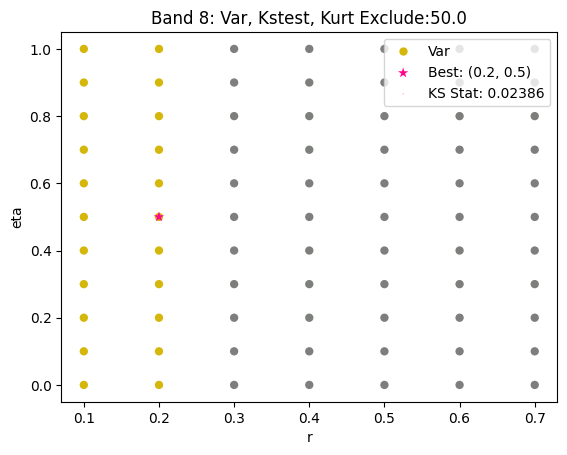

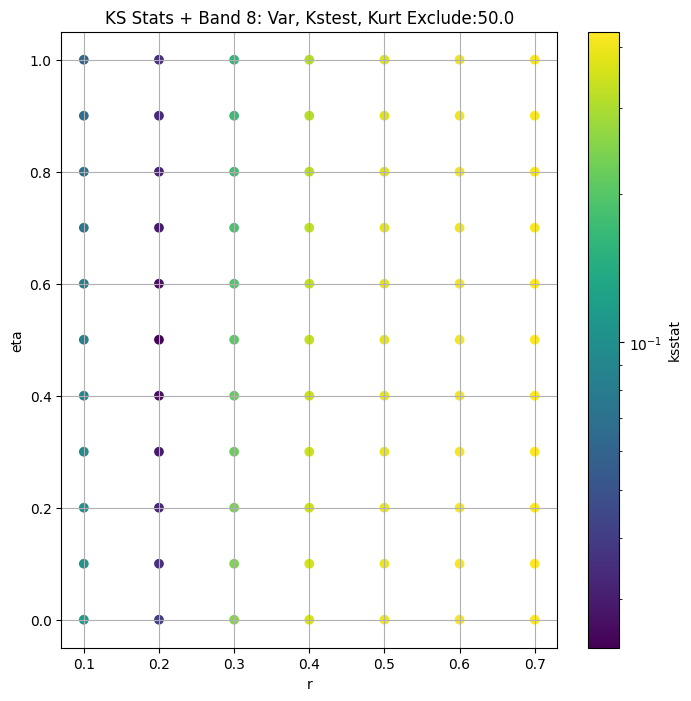

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.03160438995250536 1477210400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.031216561414412314 1462489100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.030866643233580127 1449353600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.031130408385402736 1437031700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.031628022859197455 1425308400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.032575461141515105 1403240600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.03341455651070002 1382593400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.03285307431858231 1363075300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.03287796418496465 1344496800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.03368829308400498 1326724900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.03427450592219916 1277302300.0
Number of samples: 100000, Without approximation : 100000.0


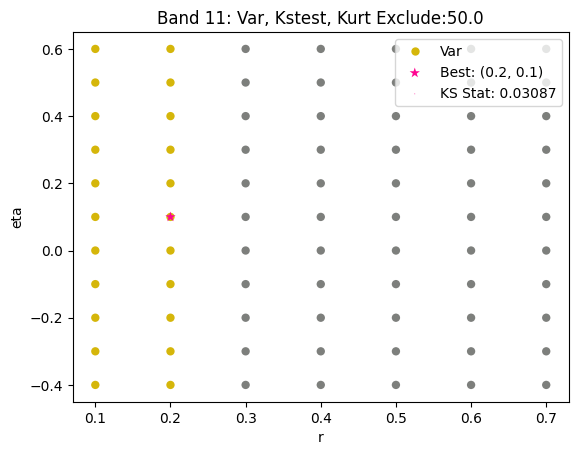

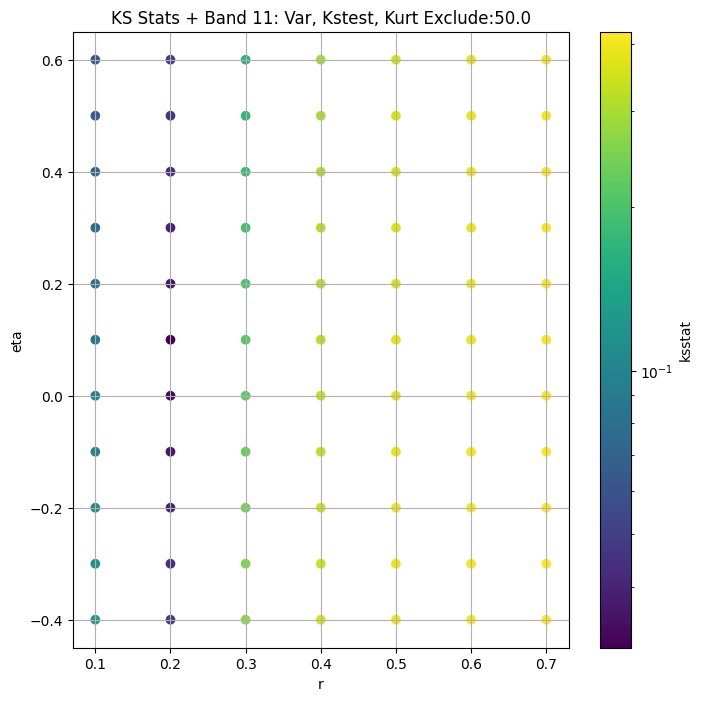

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.018093327869626474 351200400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.017490465804077593 343051900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.018514745596416304 336273950.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.019451733880853778 330196700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.020329357537537507 324612350.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.021966281629393222 314524500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.022130417522529533 305497540.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02105374152127726 297260220.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02196319339892741 289653600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.02323639909130959 282569150.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.024528712795054974 263723650.0
Number of samples: 100000, Without approximation : 100000.0


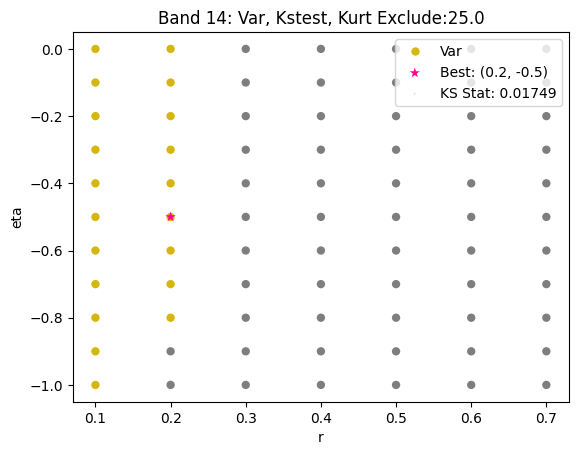

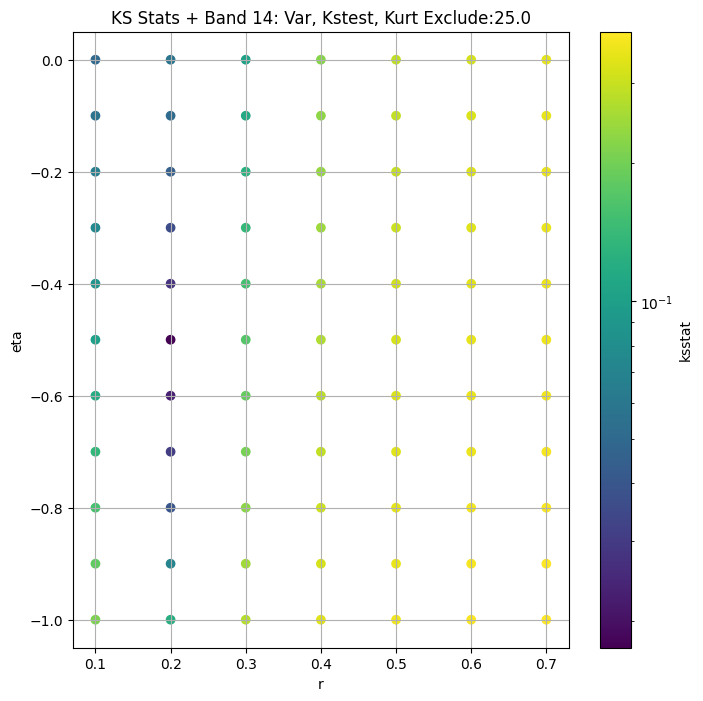

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.016070204091005777 71350696.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.0179492772237448 68940024.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.018651925383852852 67291080.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.018040665197652017 65910600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.01864752881388887 64699828.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.020416129719812215 62613250.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.02014379429058566 60830424.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.021091942290020316 59257428.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.022393125747176196 57841076.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.022004194130812338 56548876.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.02386631283190277 53220590.0
Number of samples: 100000, Without approximation : 100000.0


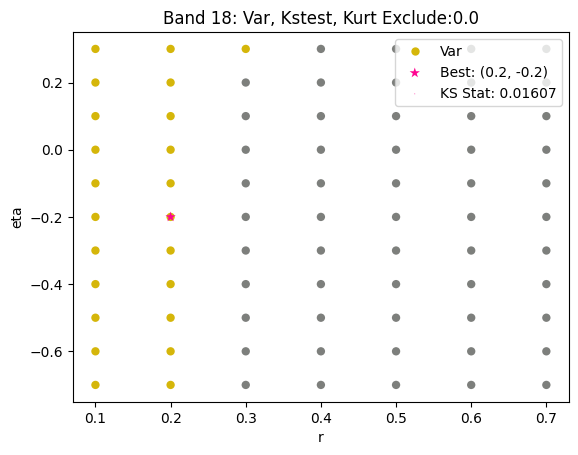

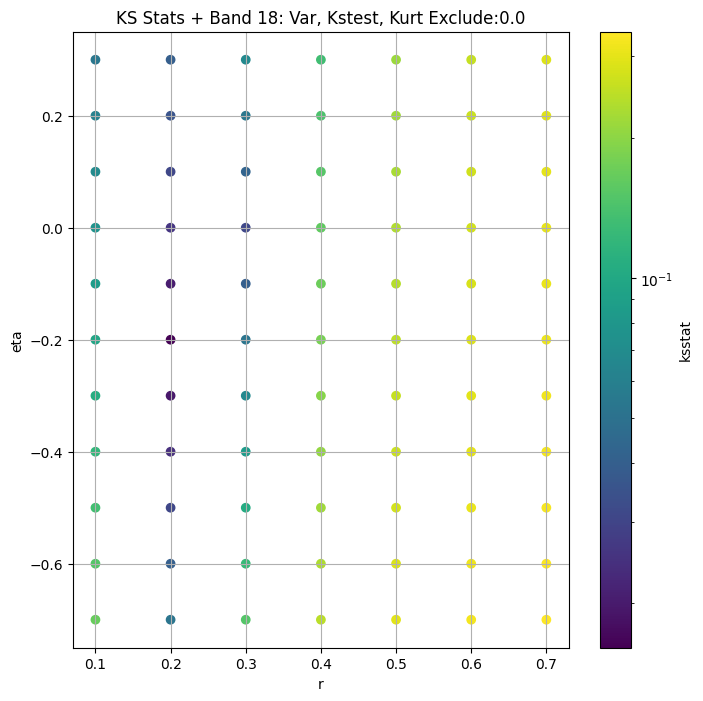

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.014821396359876587 28064408.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.015879680715665645 26764070.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.01491333882792878 25931098.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.015759753754265082 25253730.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.016993022208882436 24670456.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.019068049790222807 23689412.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.01795159851688022 22873656.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.018992087174737993 22169424.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.02046447777814063 21546870.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.021363278733078417 20986258.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.022571280851455156 19556258.0
Number of samples: 100000, Without approximation : 100000.0


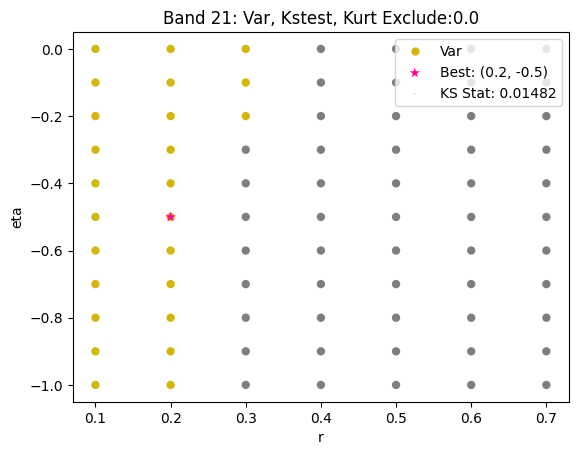

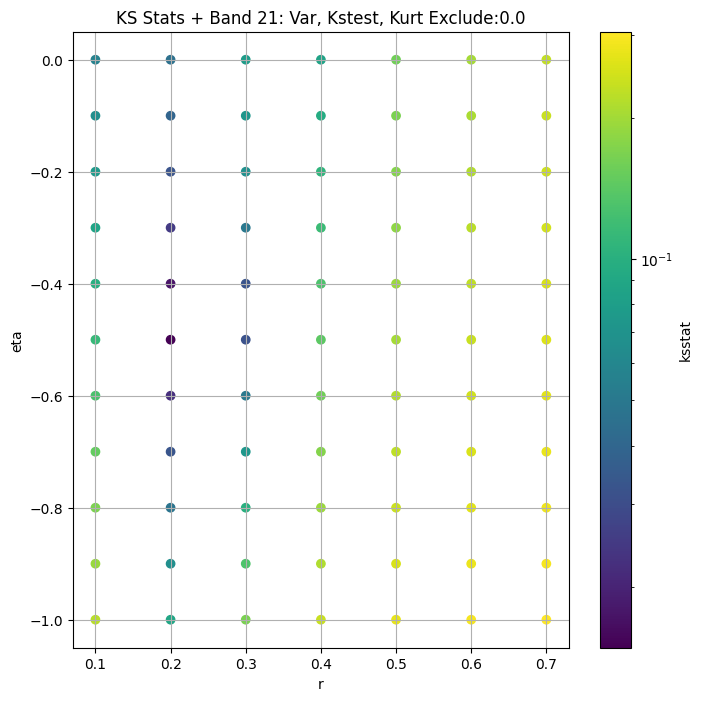

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.008048230428086327 23470622.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.009381023347729701 22338566.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.010491788030345554 21467814.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.011525138313947476 20715512.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.012504946852561982 20043370.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.014405170077967724 18869578.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.013549067082683774 17860100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.0124962372750822 16971164.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.013797077420469588 16175936.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.015063165367199538 15456833.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.018758815226241808 13641935.0
Number of samples: 100000, Without approximation : 100000.0


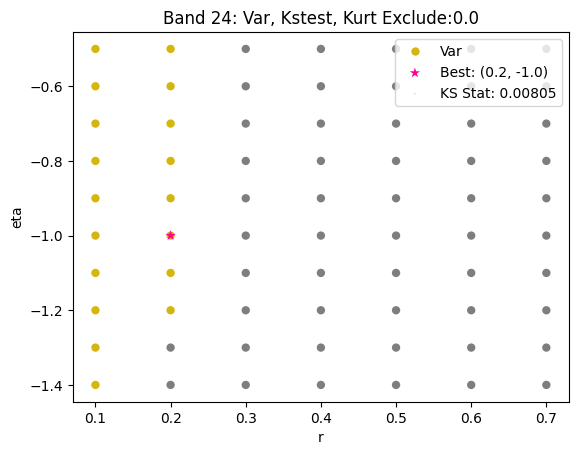

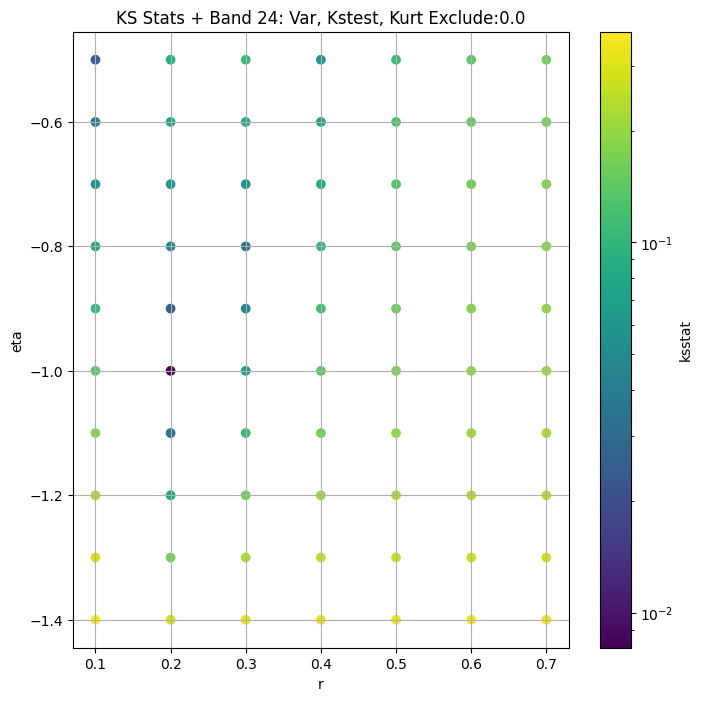

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.013162907382832933 11446037.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.012078788615450087 10827434.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.010050649387192134 10350358.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.009771316142068165 9938514.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.010802553714561403 9571533.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.012779804483155188 8932675.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.014680419703731074 8385345.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.0157929959573213 7905349.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.016767422263858012 7477362.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.017724724515539275 7091438.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.01430184468571978 6123322.5
Number of samples: 100000, Without approximation : 100000.0


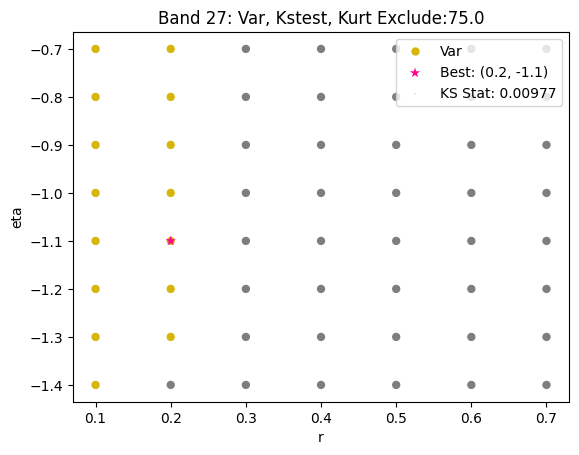

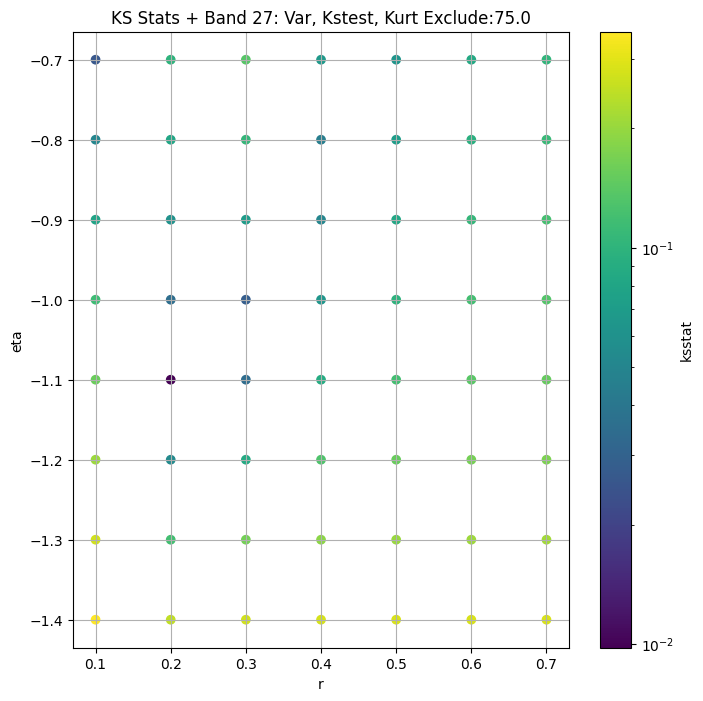

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.033209946415122205 322646.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.03305418538493299 293422.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.032959308803540754 275689.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.03287581860084077 261101.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.03280130823325356 248466.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.03267021755345978 227301.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.032557766523558795 209971.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.03245651222239887 195298.58


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.032368895296336686 182603.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.032289256617954565 171449.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.03253770852694993 144598.0
Number of samples: 100000, Without approximation : 100000.0


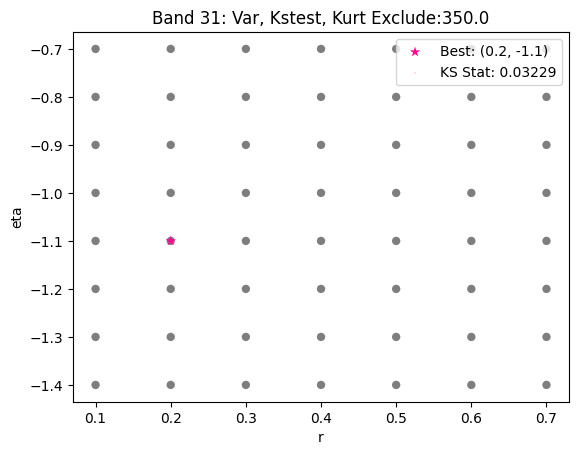

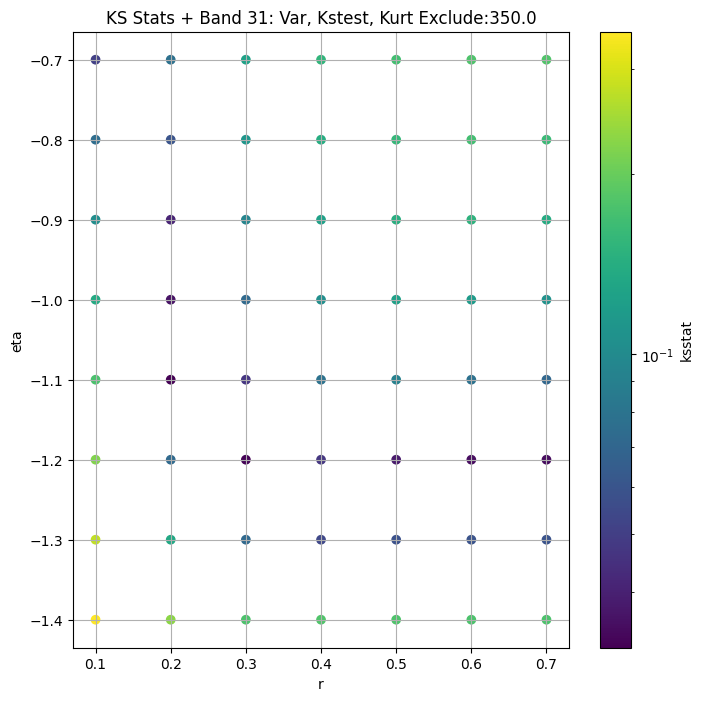

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304350e+08  8.450639e+08  1.021473e+09  11.475002    9.686062   
5     2.319913e+09  2.172740e+09  2.471595e+09   4.323010    3.781578   
8     1.712932e+09  1.609256e+09  1.820339e+09   3.816700    3.299652   
11    1.477210e+09  1.393562e+09  1.562147e+09   2.952862    2.647646   
14    3.512004e+08  3.220831e+08  3.815291e+08   8.838118    7.747682   
18    7.135070e+07  6.541452e+07  7.777086e+07   9.288547    7.105037   
21    2.806441e+07  2.528724e+07  3.112942e+07  14.143866   10.129042   
24    2.347062e+07  2.053493e+07  2.665636e+07  23.600979   19.822874   
27    1.144604e+07  9.863044e+06  1.315475e+07  29.179123   24.510862   
31    3.226470e+05  2.673852e+05  3.902298e+05  51.517807   34.074745   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.108884       100000.0             0.023541        0.1          0.0   
5       4.905125       100000.0             0.032234        0.2         -0.1   
8       4.357325       100000.0             0.023858        0.2          0.5   
11      3.273485       100000.0             0.030867        0.2          0.1   
14     10.001733       100000.0             0.017490        0.2         -0.5   
18     12.427702       100000.0             0.016070        0.2         -0.2   
21     20.413070       100000.0             0.014821        0.2         -0.5   
24     27.856232       100000.0             0.008048        0.2         -1.0   
27     34.519924       100000.0             0.009771        0.2         -1.1   
31    113.403180       100000.0             0.032289        0.2         -1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000131                     0.0        9.304350e+08   
5      41203.684848                    25.0        2.284332e+09   
8       6934.925341                    50.0        1.666046e+09   
11     15249.932660                    50.0        1.449354e+09   
14     22688.617989                    25.0        3.430519e+08   
18      1726.202589                     0.0        7.135070e+07   
21      1856.111640                     0.0        2.806441e+07   
24     16673.546542                     0.0        2.347062e+07   
27     13803.491667                    75.0        9.938514e+06   
31       238.124349                   350.0        1.714495e+05   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
5                    0.004293  
8                    0.004293  
11                   0.004293  
14                   0.004293  
18                   0.004293  
21                   0.004293  
24                   0.004293  
27                   0.004293  
31                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.0242550729069671, var: 848397248.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.023982186833393176, var: 864388992.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.02334089086937799, var: 881871936.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.022622589150012473, var: 901785152.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.021620991432042103, var: 930435008.0
Number of samples: 100000, Without approximation : 100000.0


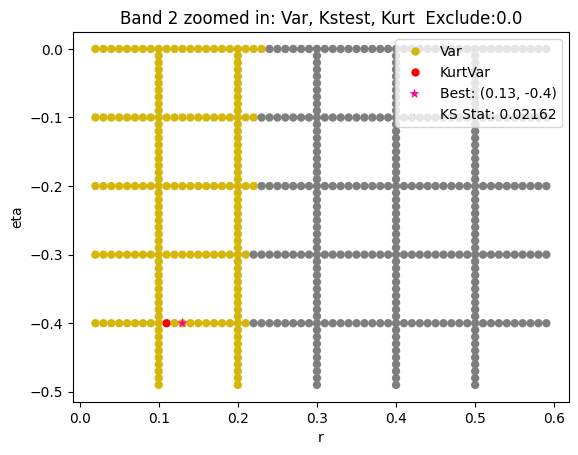

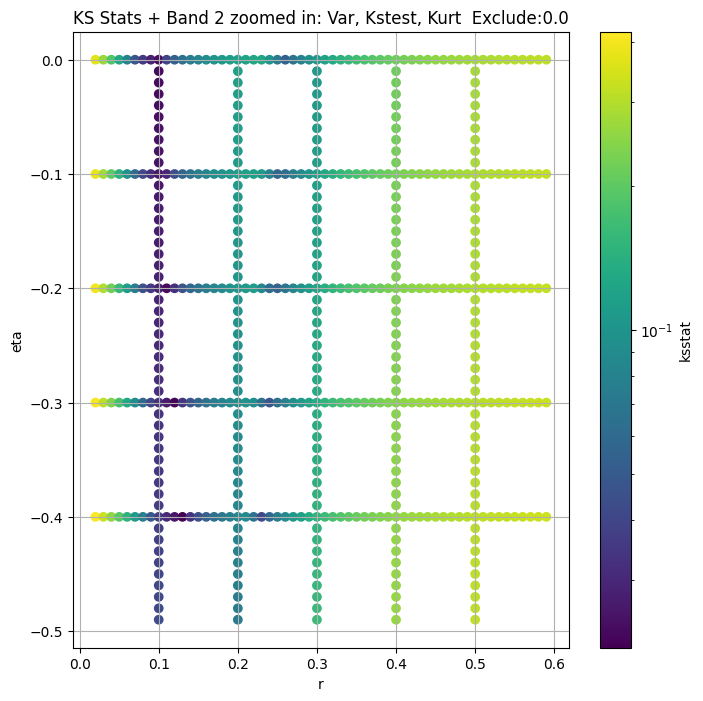

Band 5


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 100 = 125, ksstat: 0.03312308056670707, var: 2179944192.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 75 = 100, ksstat: 0.032794490509635066, var: 2203254528.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 50 = 75, ksstat: 0.03243668725964877, var: 2228058368.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 25 = 50, ksstat: 0.03231994148374895, var: 2254782208.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 0 = 25, ksstat: 0.03193085658156186, var: 2284332288.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + -25 = 0, ksstat: 0.031693380933705384, var: 2319912704.0
Number of samples: 100000, Without approximation : 100000.0


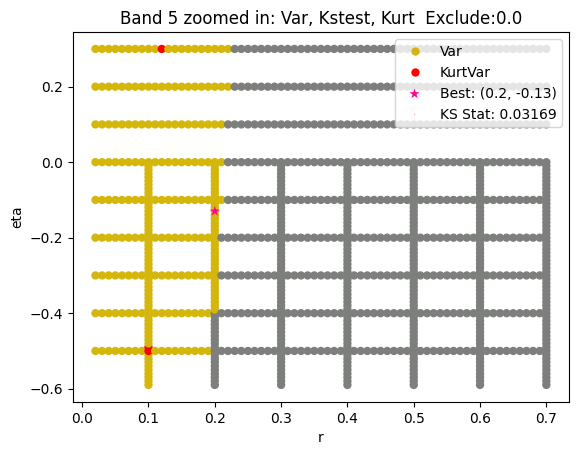

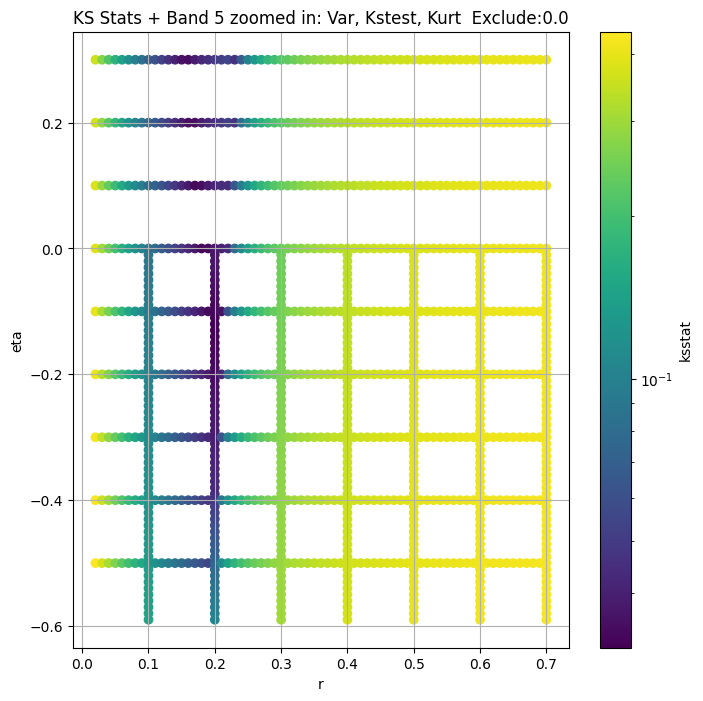

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 100 = 150, ksstat: 0.02404113682850162, var: 1595643264.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 75 = 125, ksstat: 0.02433896841556843, var: 1611453056.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 50 = 100, ksstat: 0.02465471008558684, var: 1628277248.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 25 = 75, ksstat: 0.024034022030437086, var: 1646371328.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 0 = 50, ksstat: 0.023213807509971263, var: 1666046464.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + -25 = 25, ksstat: 0.023595644581307584, var: 1687740544.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + -50 = 0, ksstat: 0.023827098567124394, var: 1712931968.0
Number of samples: 100000, Without approximation : 100000.0


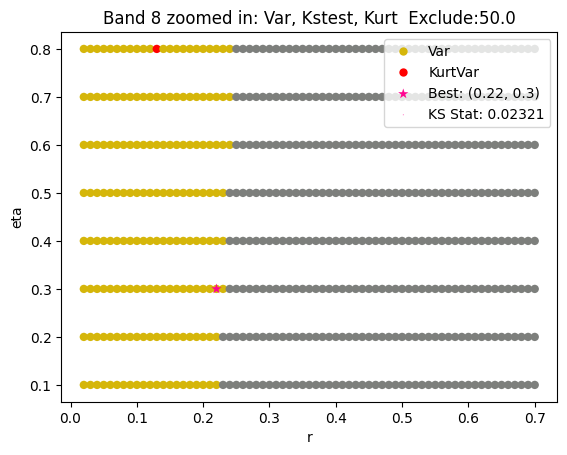

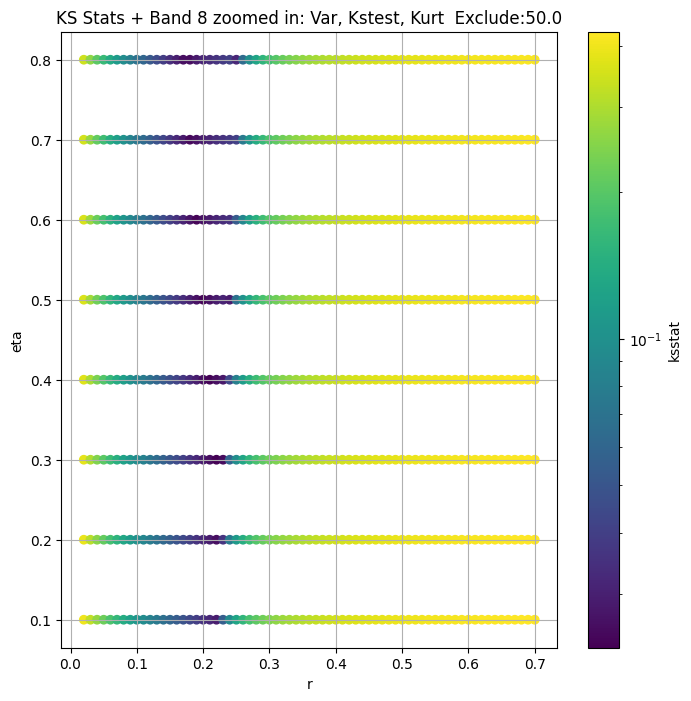

Band 11


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 100 = 150, ksstat: 0.0317464611932759, var: 1403240576.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 75 = 125, ksstat: 0.03204943698405116, var: 1414071552.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 50 = 100, ksstat: 0.031628022859197455, var: 1425308416.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 25 = 75, ksstat: 0.031130408385402736, var: 1437031680.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + 0 = 50, ksstat: 0.03077553959475926, var: 1449353600.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + -25 = 25, ksstat: 0.030227349163783418, var: 1462489088.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 50.0 + -50 = 0, ksstat: 0.03039396675925876, var: 1477210368.0
Number of samples: 100000, Without approximation : 100000.0


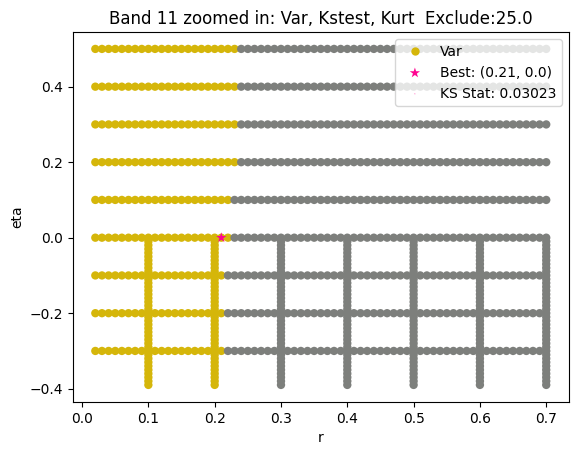

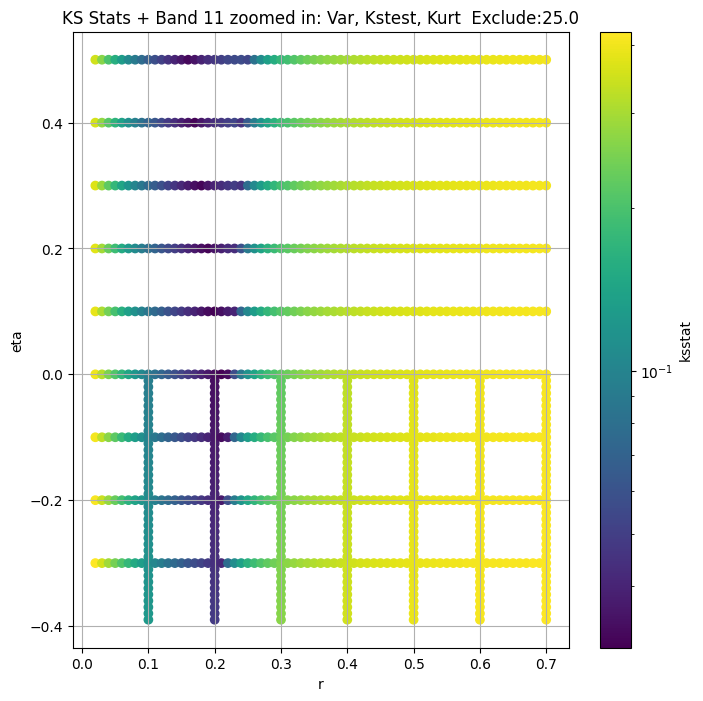

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.019293258559618054, var: 319410848.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.018968490223324433, var: 324612352.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.01853583602265274, var: 330196704.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.01805240180355505, var: 336273952.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.017490465804077593, var: 343051904.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.017062053479735995, var: 351200384.0
Number of samples: 100000, Without approximation : 100000.0


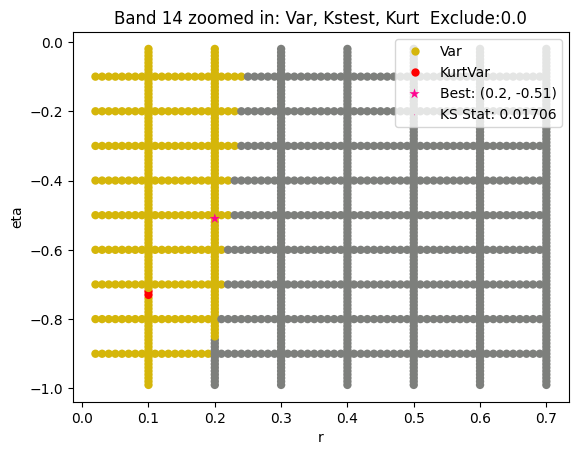

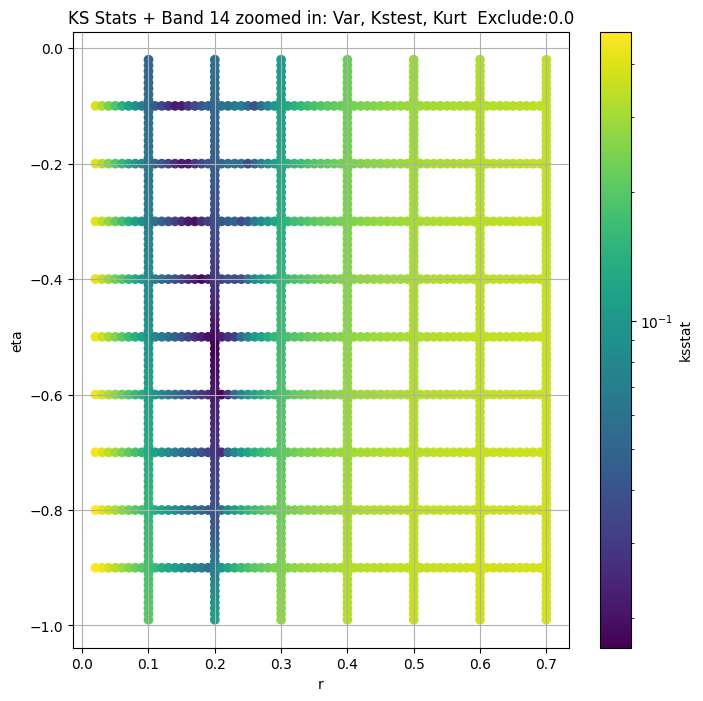

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.017060395535213047, var: 64699828.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.01607537105512369, var: 65910600.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.016673611577593173, var: 67291080.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.015423228329095512, var: 68940024.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.015056396888700654, var: 71350696.0
Number of samples: 100000, Without approximation : 100000.0


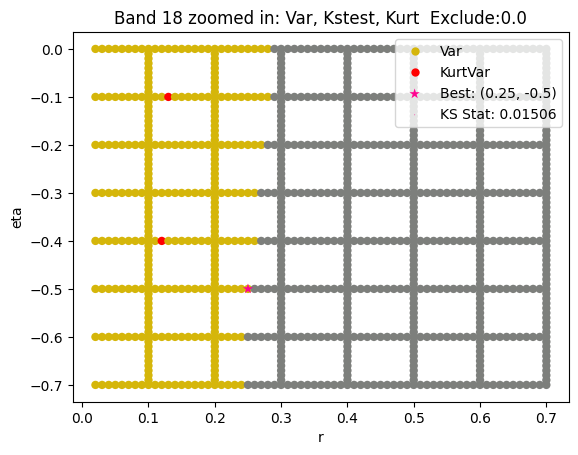

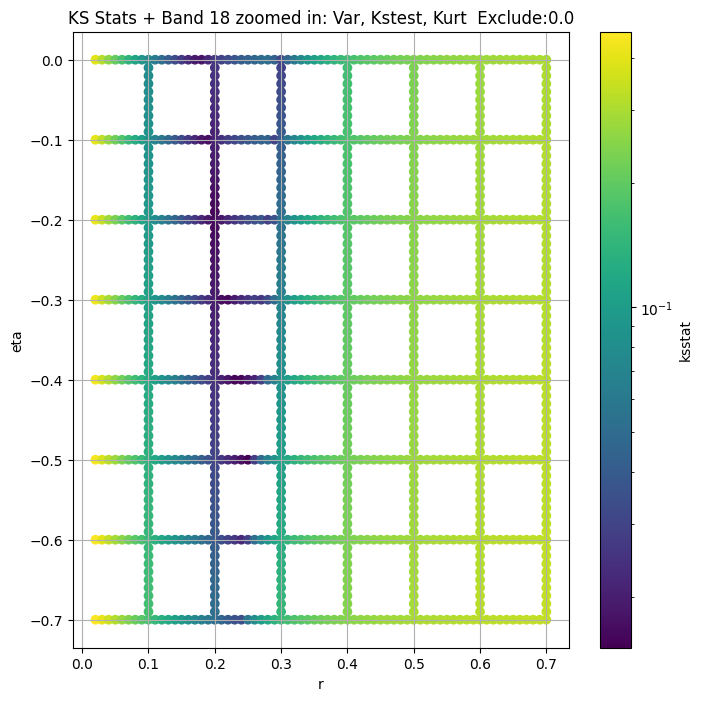

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 100 = 100, ksstat: 0.014262497876424418, var: 24670456.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 75 = 75, ksstat: 0.014128064725903, var: 25253730.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 50 = 50, ksstat: 0.012772520888170089, var: 25931098.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 25 = 25, ksstat: 0.0115744373211224, var: 26764070.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 0 = 0, ksstat: 0.011327309779567446, var: 28064408.0
Number of samples: 100000, Without approximation : 100000.0


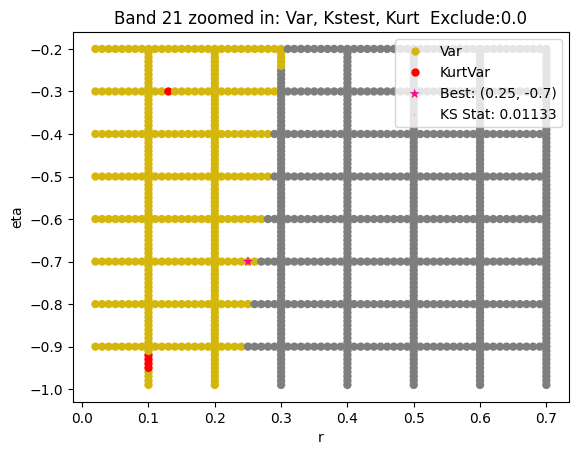

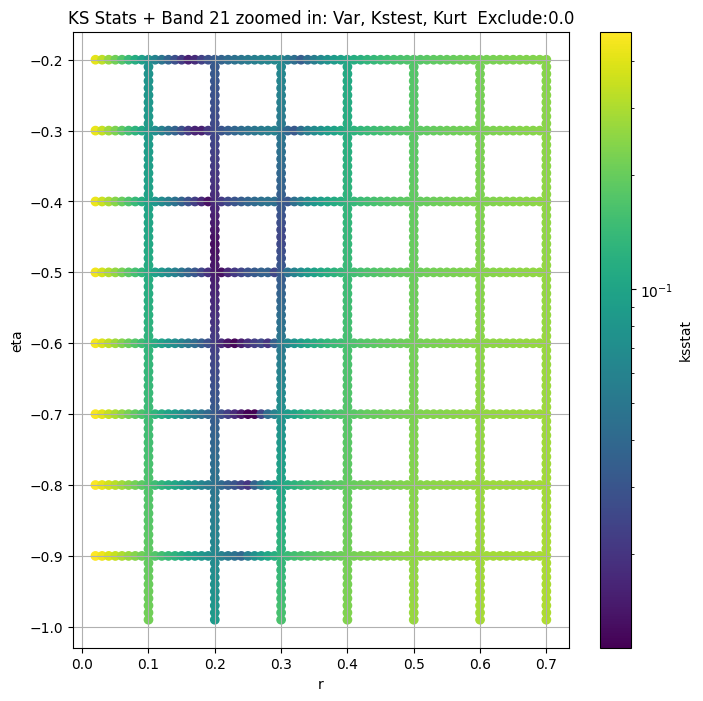

Band 24


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 100 = 100, ksstat: 0.008770879071885083, var: 20043370.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 75 = 75, ksstat: 0.00910615758651686, var: 20715512.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 50 = 50, ksstat: 0.008546988057332408, var: 21467814.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 25 = 25, ksstat: 0.007542882696820477, var: 22338566.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 0 = 0, ksstat: 0.007143076084460111, var: 23470622.0
Number of samples: 100000, Without approximation : 100000.0


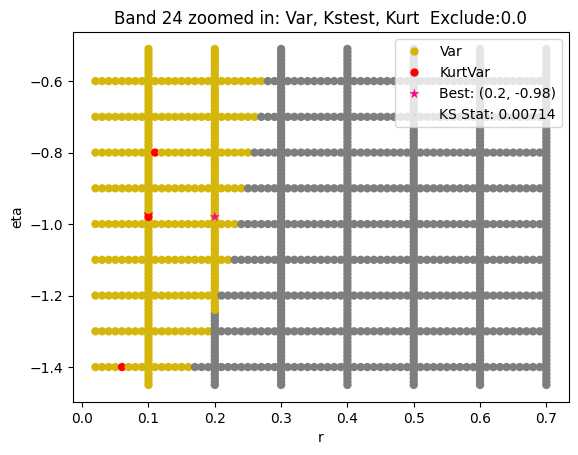

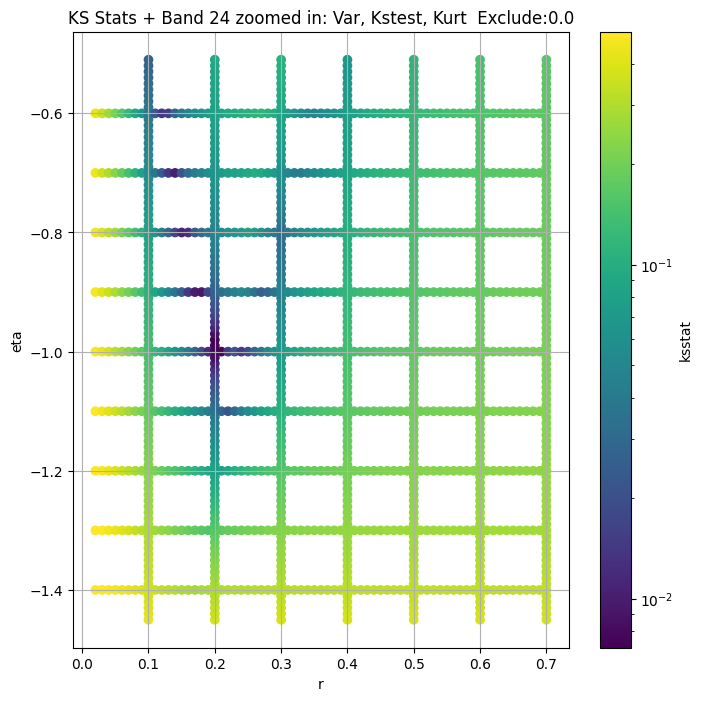

Band 27


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 100 = 175, ksstat: 0.010166573649241648, var: 8649370.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 75 = 150, ksstat: 0.010044397069910671, var: 8932675.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 50 = 125, ksstat: 0.009821026845708493, var: 9238547.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 25 = 100, ksstat: 0.00962271484256605, var: 9571533.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 0 = 75, ksstat: 0.009771316142068165, var: 9938514.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -25 = 50, ksstat: 0.010050649387192134, var: 10350358.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -50 = 25, ksstat: 0.010926437166981995, var: 10827434.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -75 = 0, ksstat: 0.011261522443184013, var: 11446037.0
Number of samples: 100000, Without approximation : 100000.0


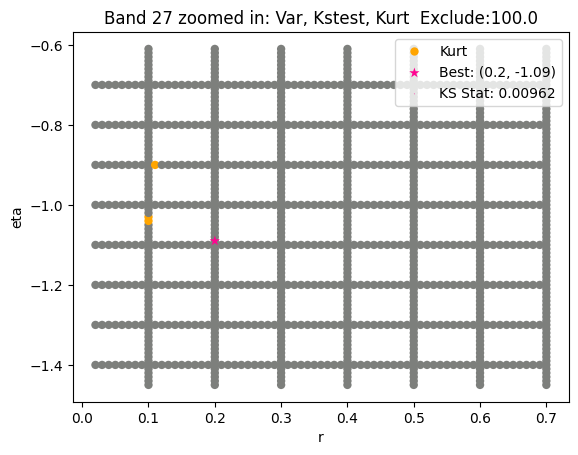

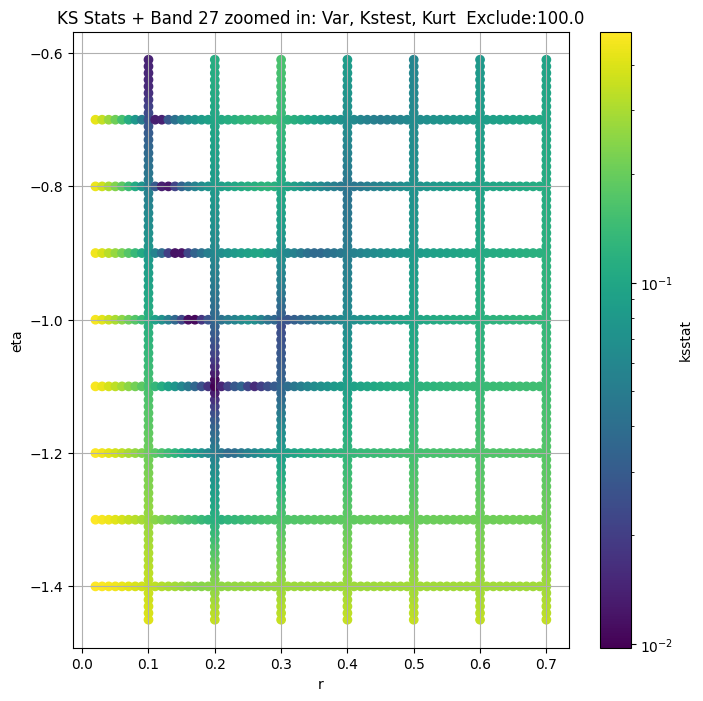

Band 31


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 100 = 450, ksstat: 0.02831460686910403, var: 152641.390625


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 75 = 425, ksstat: 0.02831460686910403, var: 156972.875


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 50 = 400, ksstat: 0.02831460686910403, var: 161536.21875


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 25 = 375, ksstat: 0.02831460686910403, var: 166353.265625


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 0 = 350, ksstat: 0.02831460686910403, var: 171449.53125


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -25 = 325, ksstat: 0.02831460686910403, var: 176854.90625


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -50 = 300, ksstat: 0.02831460686910403, var: 182603.015625


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -75 = 275, ksstat: 0.02831460686910403, var: 188734.375


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -100 = 250, ksstat: 0.02831460686910403, var: 195298.578125
Number of samples: 100000, Without approximation : 100000.0


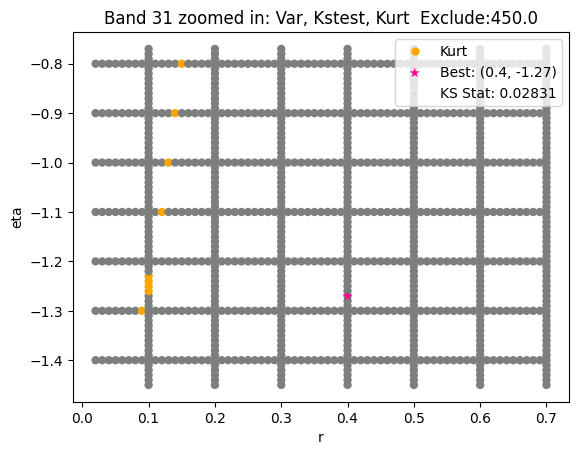

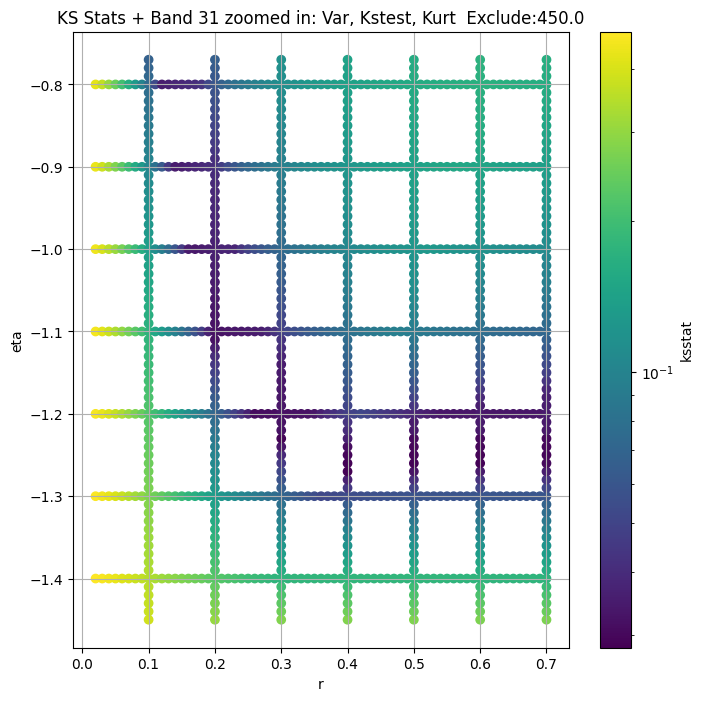

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304350e+08  8.450639e+08  1.021473e+09  11.475002    9.686062   
5     2.319913e+09  2.172740e+09  2.471595e+09   4.323010    3.781578   
8     1.712932e+09  1.609256e+09  1.820339e+09   3.816700    3.299652   
11    1.477210e+09  1.393562e+09  1.562147e+09   2.952862    2.647646   
14    3.512004e+08  3.220831e+08  3.815291e+08   8.838118    7.747682   
18    7.135070e+07  6.541452e+07  7.777086e+07   9.288547    7.105037   
21    2.806441e+07  2.528724e+07  3.112942e+07  14.143866   10.129042   
24    2.347062e+07  2.053493e+07  2.665636e+07  23.600979   19.822874   
27    1.144604e+07  9.863044e+06  1.315475e+07  29.179123   24.510862   
31    3.226470e+05  2.673852e+05  3.902298e+05  51.517807   34.074745   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.108884       100000.0             0.023541        0.1          0.0   
5       4.905125       100000.0             0.032234        0.2         -0.1   
8       4.357325       100000.0             0.023858        0.2          0.5   
11      3.273485       100000.0             0.030867        0.2          0.1   
14     10.001733       100000.0             0.017490        0.2         -0.5   
18     12.427702       100000.0             0.016070        0.2         -0.2   
21     20.413070       100000.0             0.014821        0.2         -0.5   
24     27.856232       100000.0             0.008048        0.2         -1.0   
27     34.519924       100000.0             0.009771        0.2         -1.1   
31    113.403180       100000.0             0.032289        0.2         -1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000131                     0.0        9.304350e+08   
5      41203.684848                    25.0        2.319913e+09   
8       6934.925341                    50.0        1.666046e+09   
11     15249.932660                    50.0        1.462489e+09   
14     22688.617989                    25.0        3.512004e+08   
18      1726.202589                     0.0        7.135070e+07   
21      1856.111640                     0.0        2.806441e+07   
24     16673.546542                     0.0        2.347062e+07   
27     13803.491667                    75.0        9.571533e+06   
31       238.124349                   350.0        1.526414e+05   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.021621    0.13     -0.40   
5                    0.004293          0.031693    0.20     -0.13   
8                    0.004293          0.023214    0.22      0.30   
11                   0.004293          0.030227    0.21      0.00   
14                   0.004293          0.017062    0.20     -0.51   
18                   0.004293          0.015056    0.25     -0.50   
21                   0.004293          0.011327    0.25     -0.70   
24                   0.004293          0.007143    0.20     -0.98   
27                   0.004293          0.009623    0.20     -1.09   
31                   0.004293          0.028315    0.40     -1.27   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2          6.042347                  0.0         3952  
5      45614.421938                  0.0         1756  
8      50324.220540                 50.0         3514  
11     43550.844790                 25.0         1975  
14     24113.366600                  0.0         6250  
18     84941.304762                  0.0         7908  
21     64768.163624                  0.0        14062  
24     14748.877079                

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

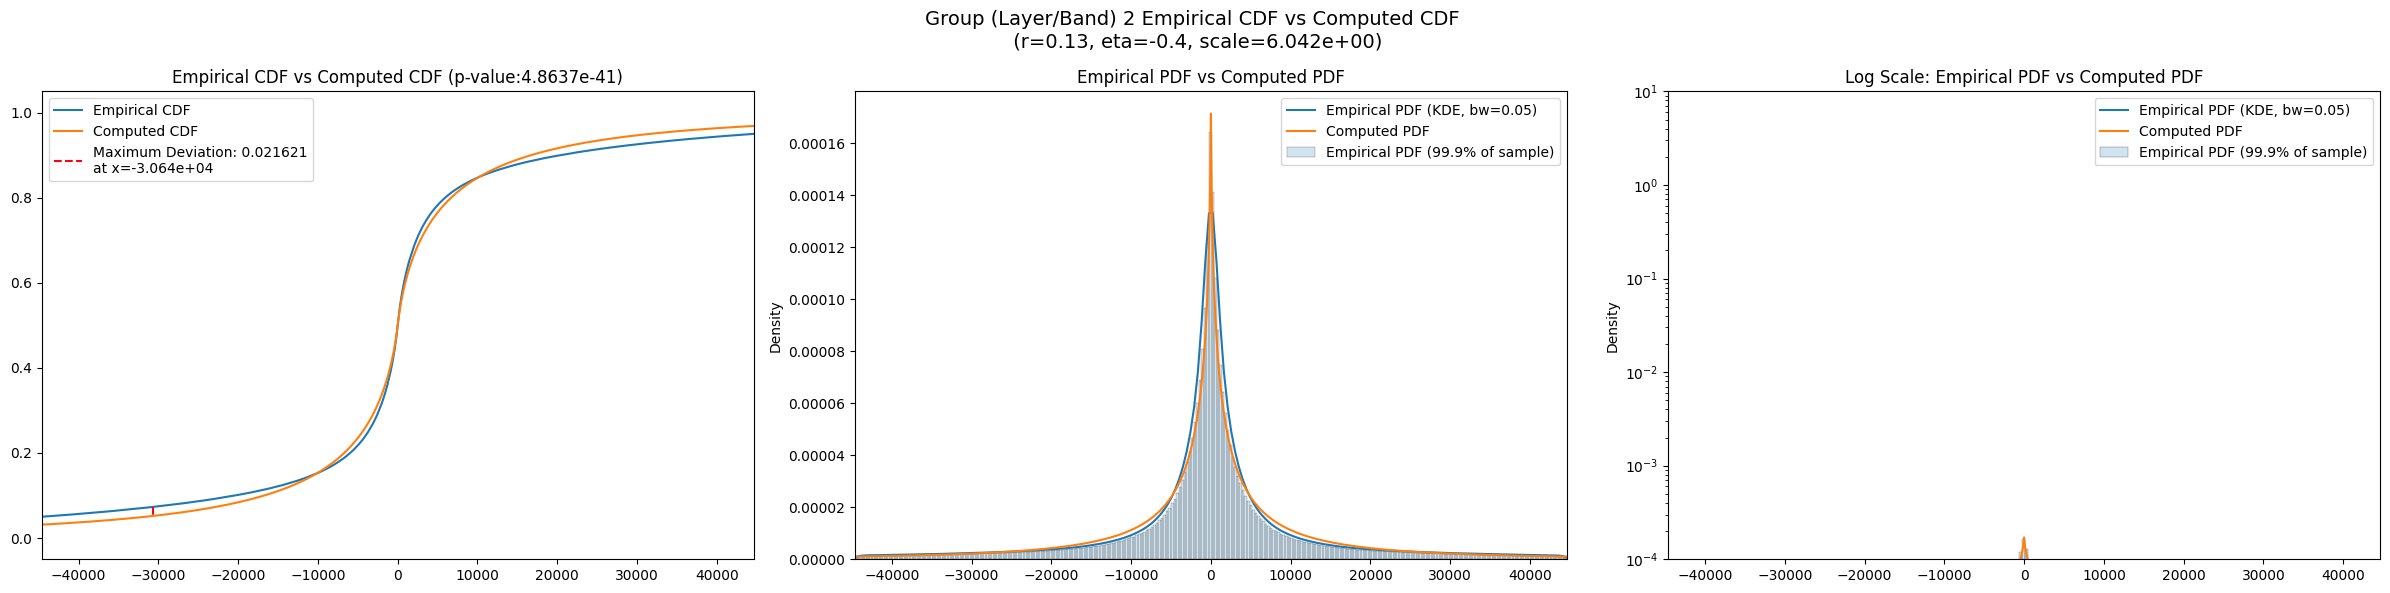

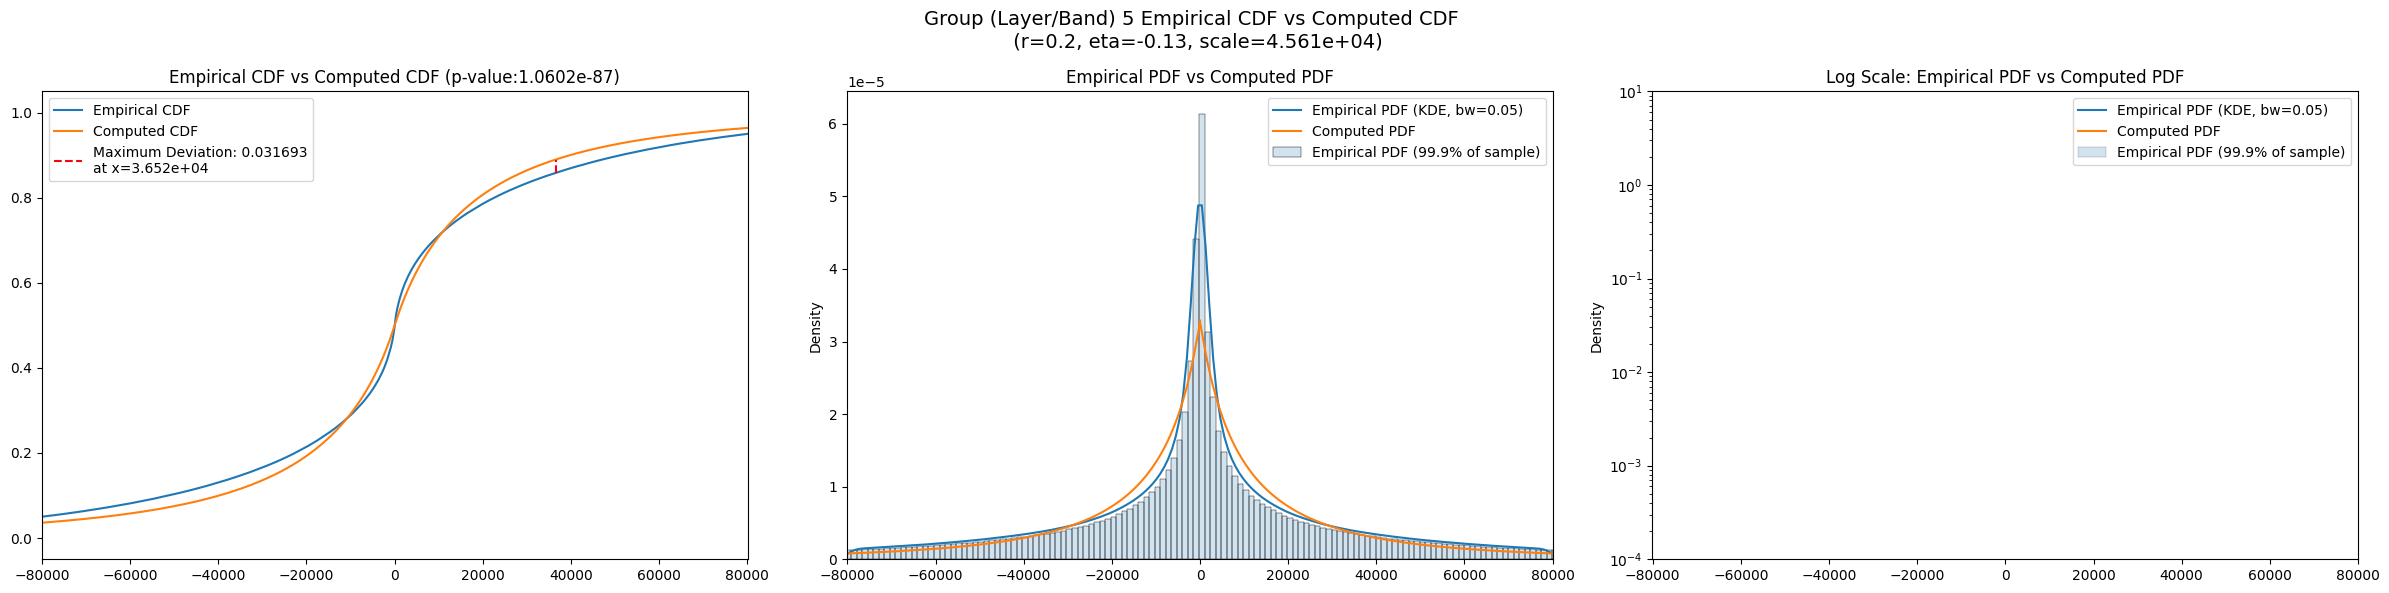

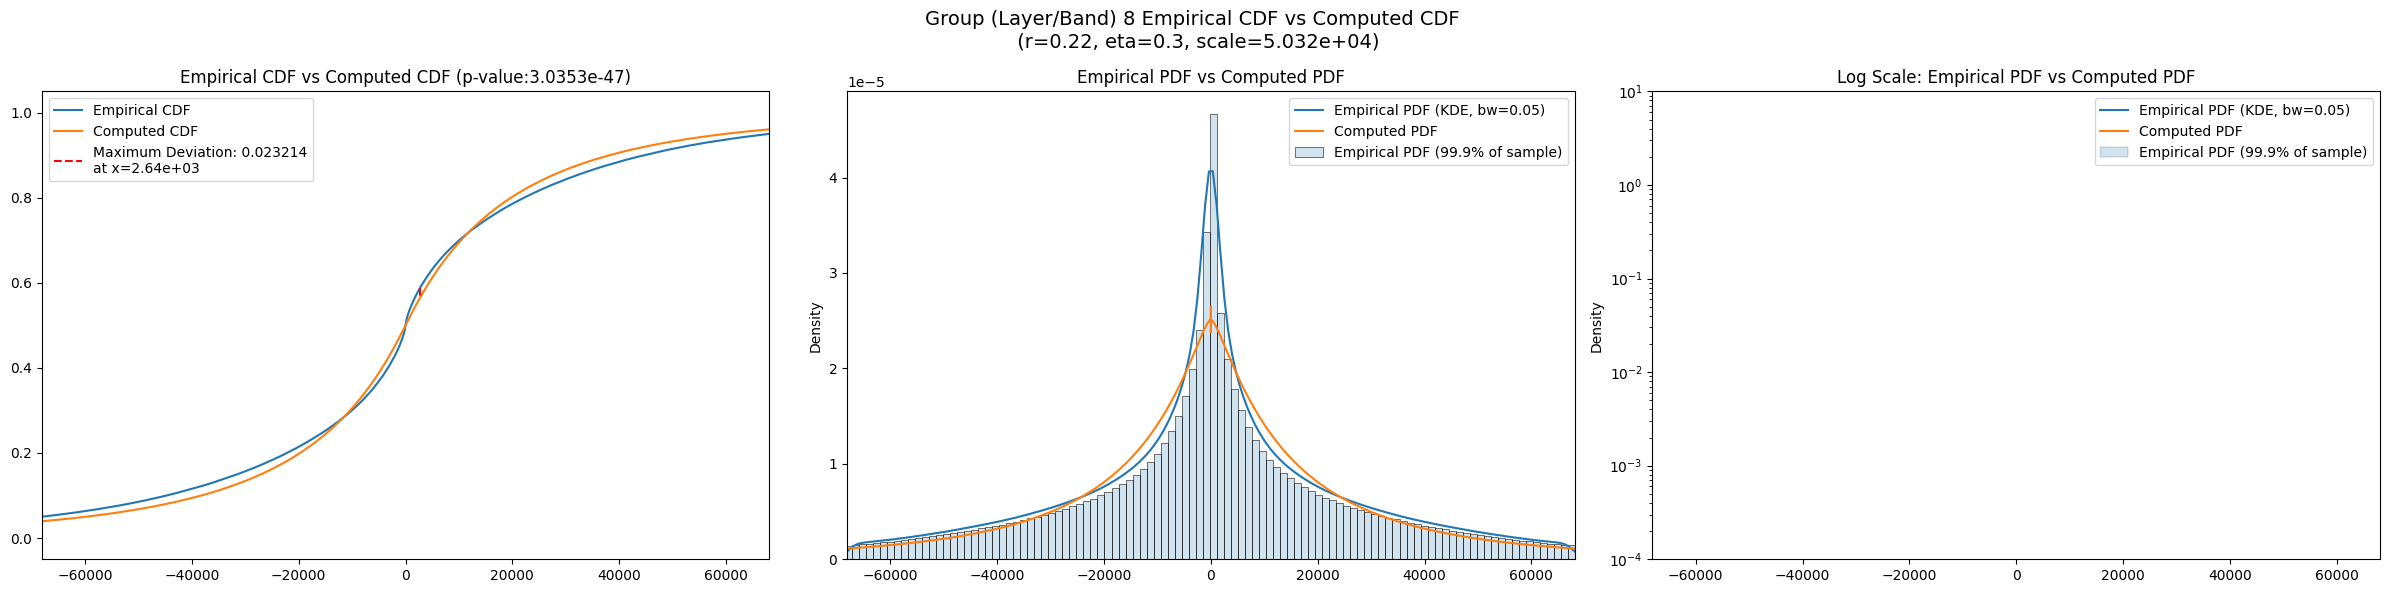

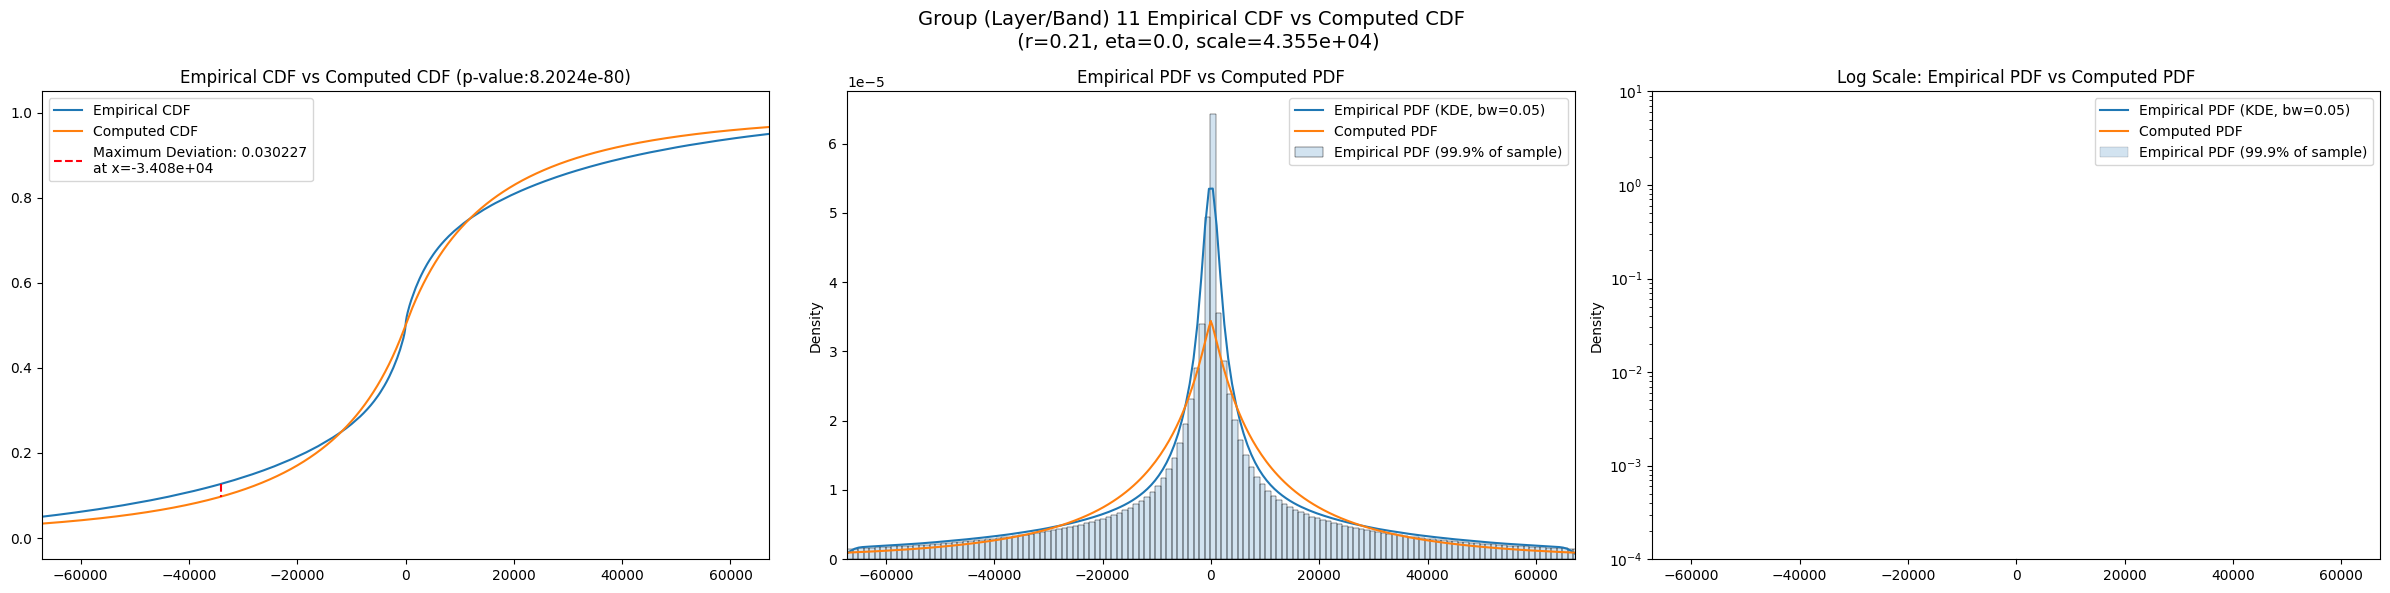

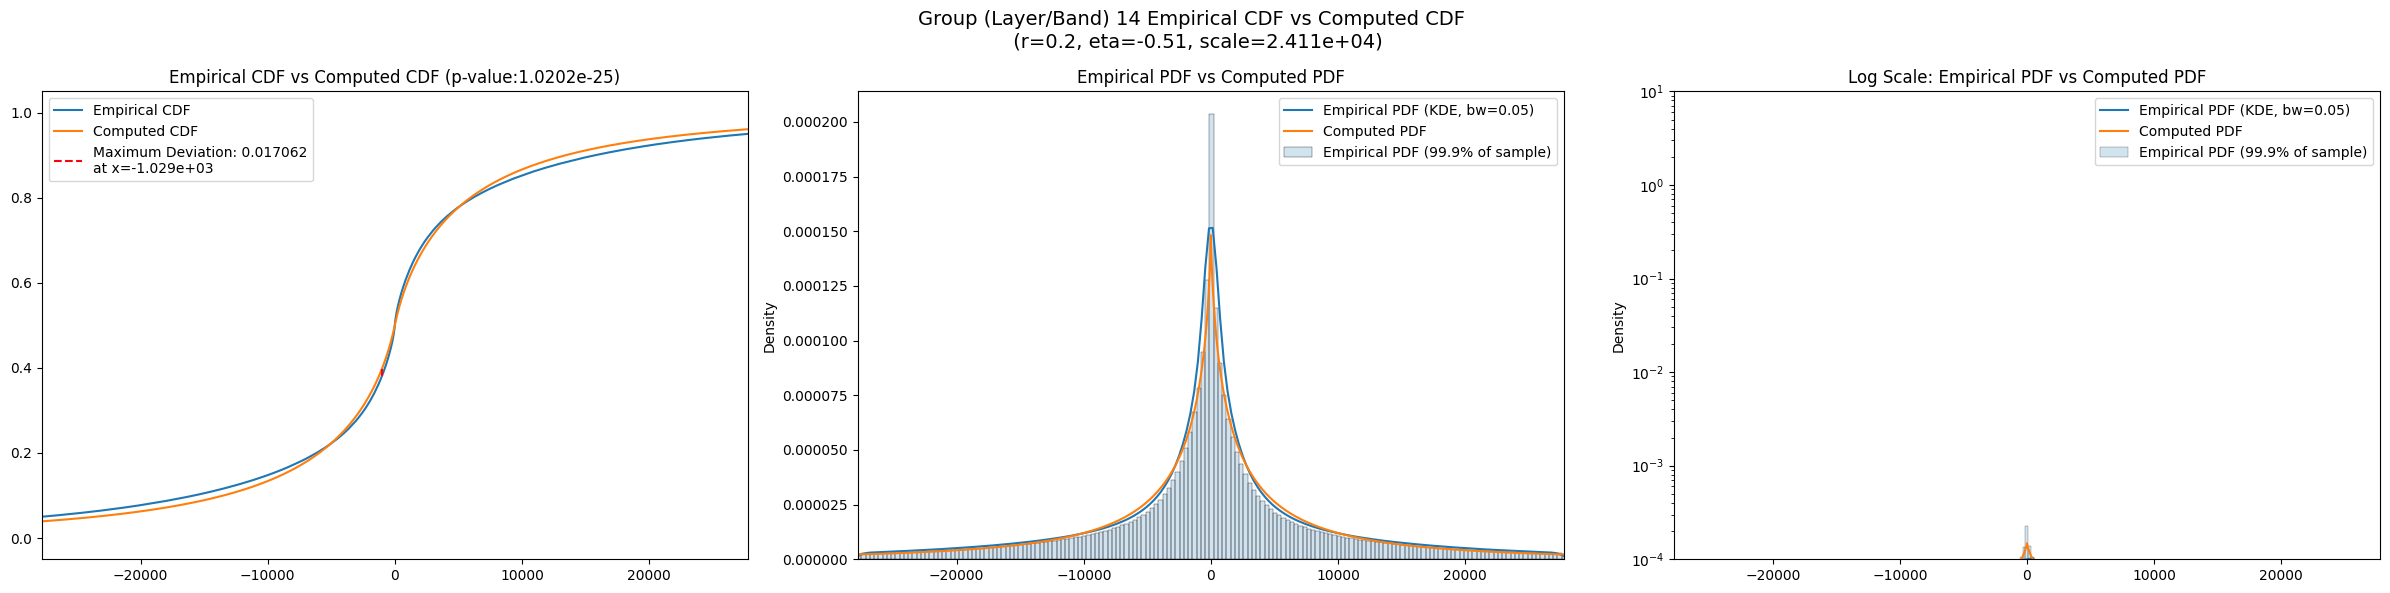

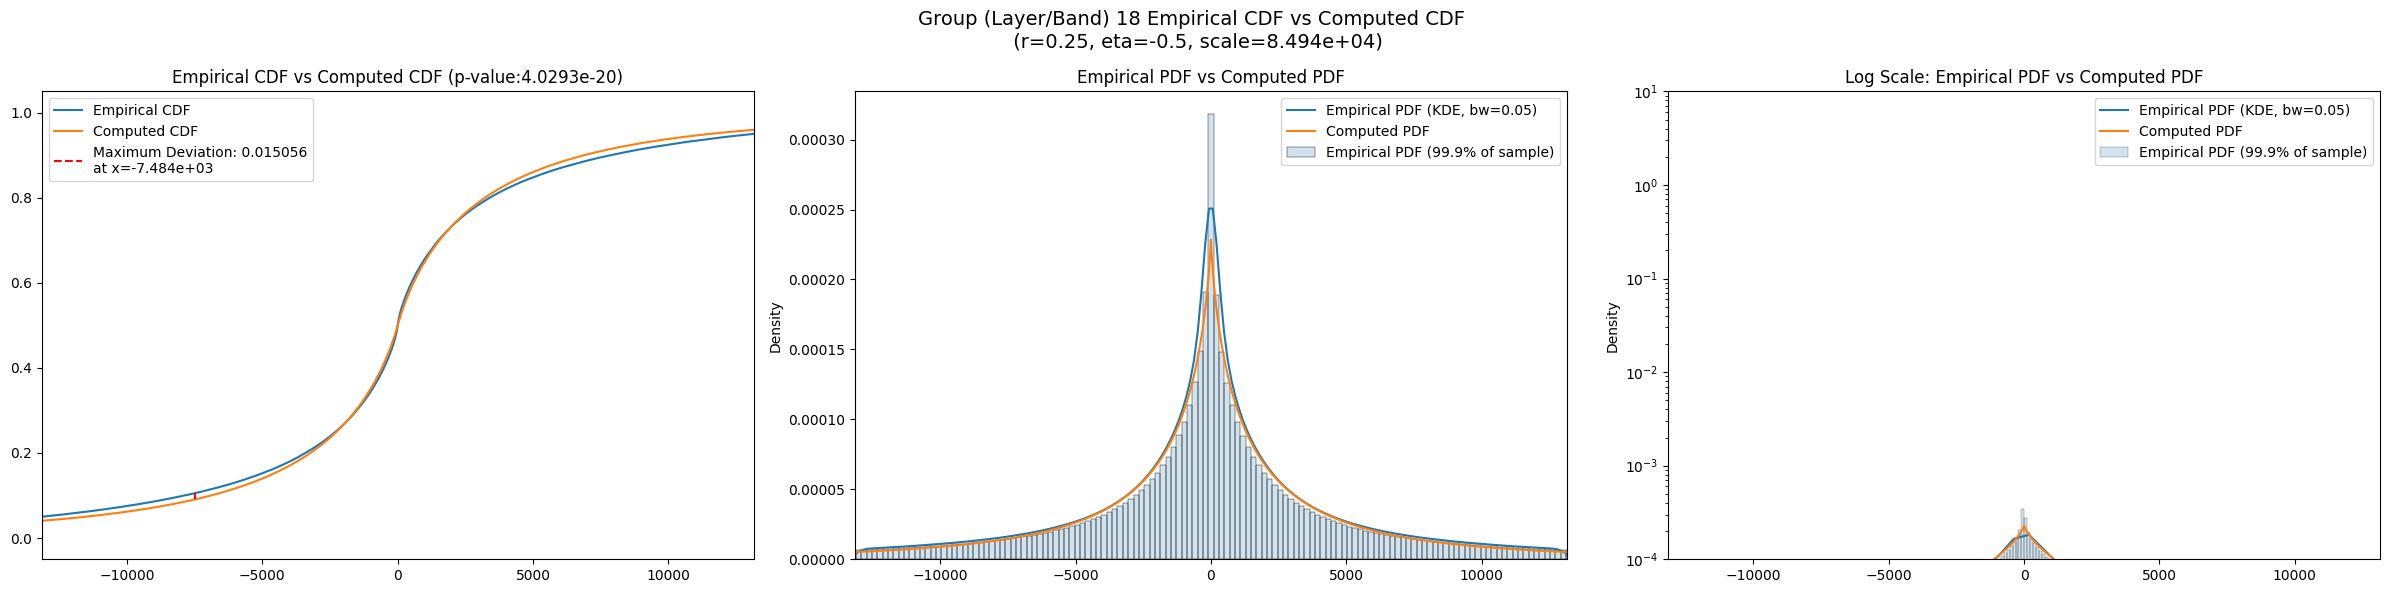

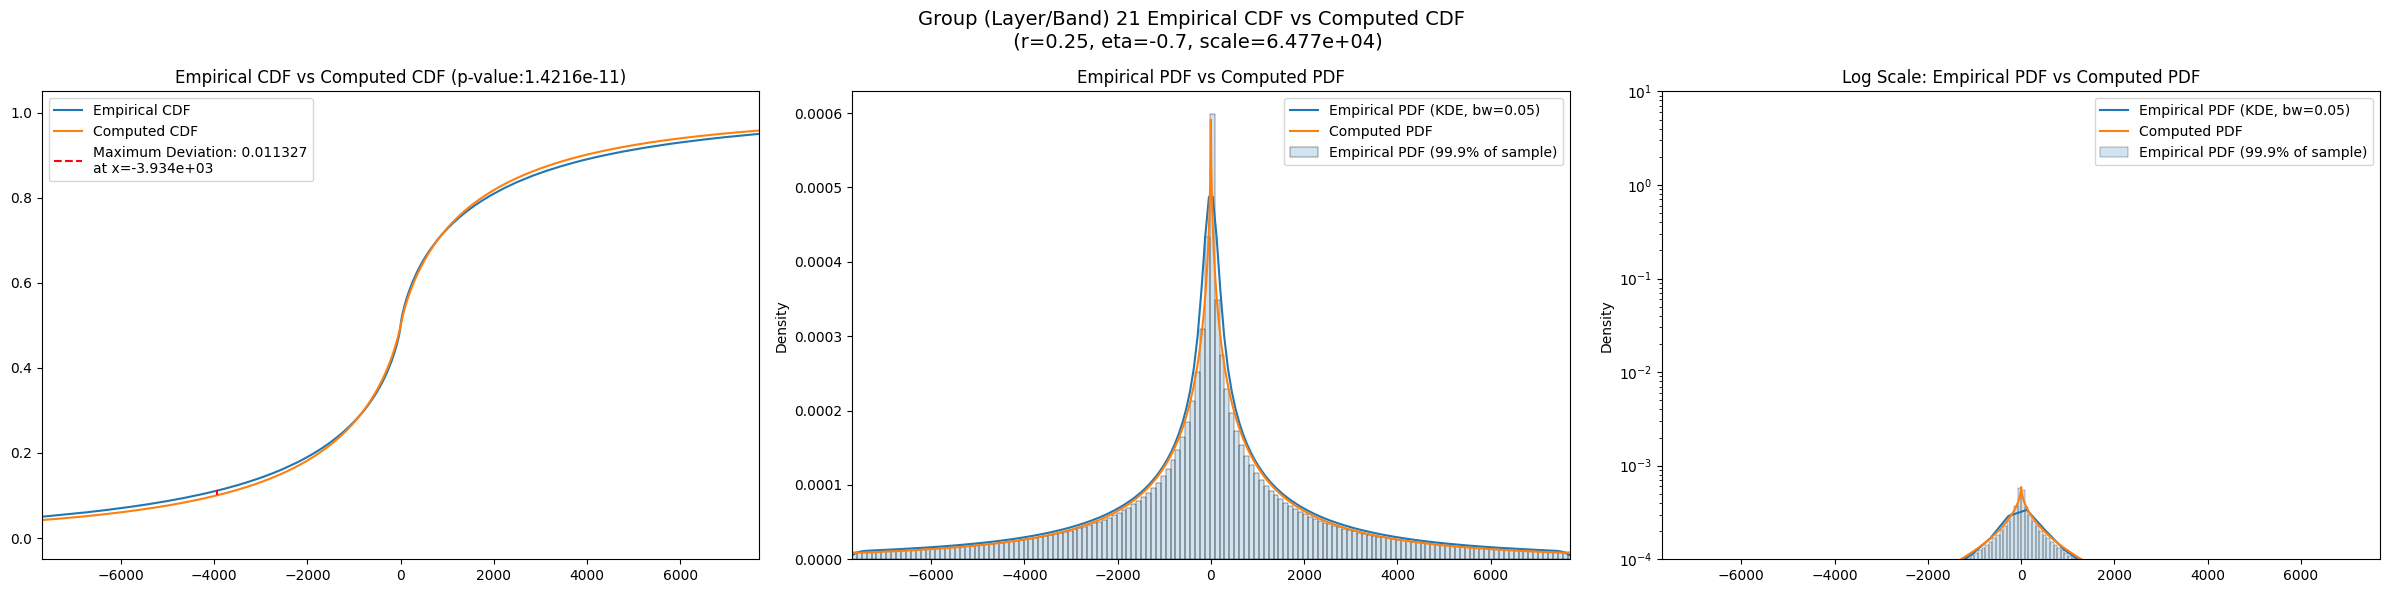

C:\Users\Henry\AppData\Local\Temp\ipykernel_34140\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


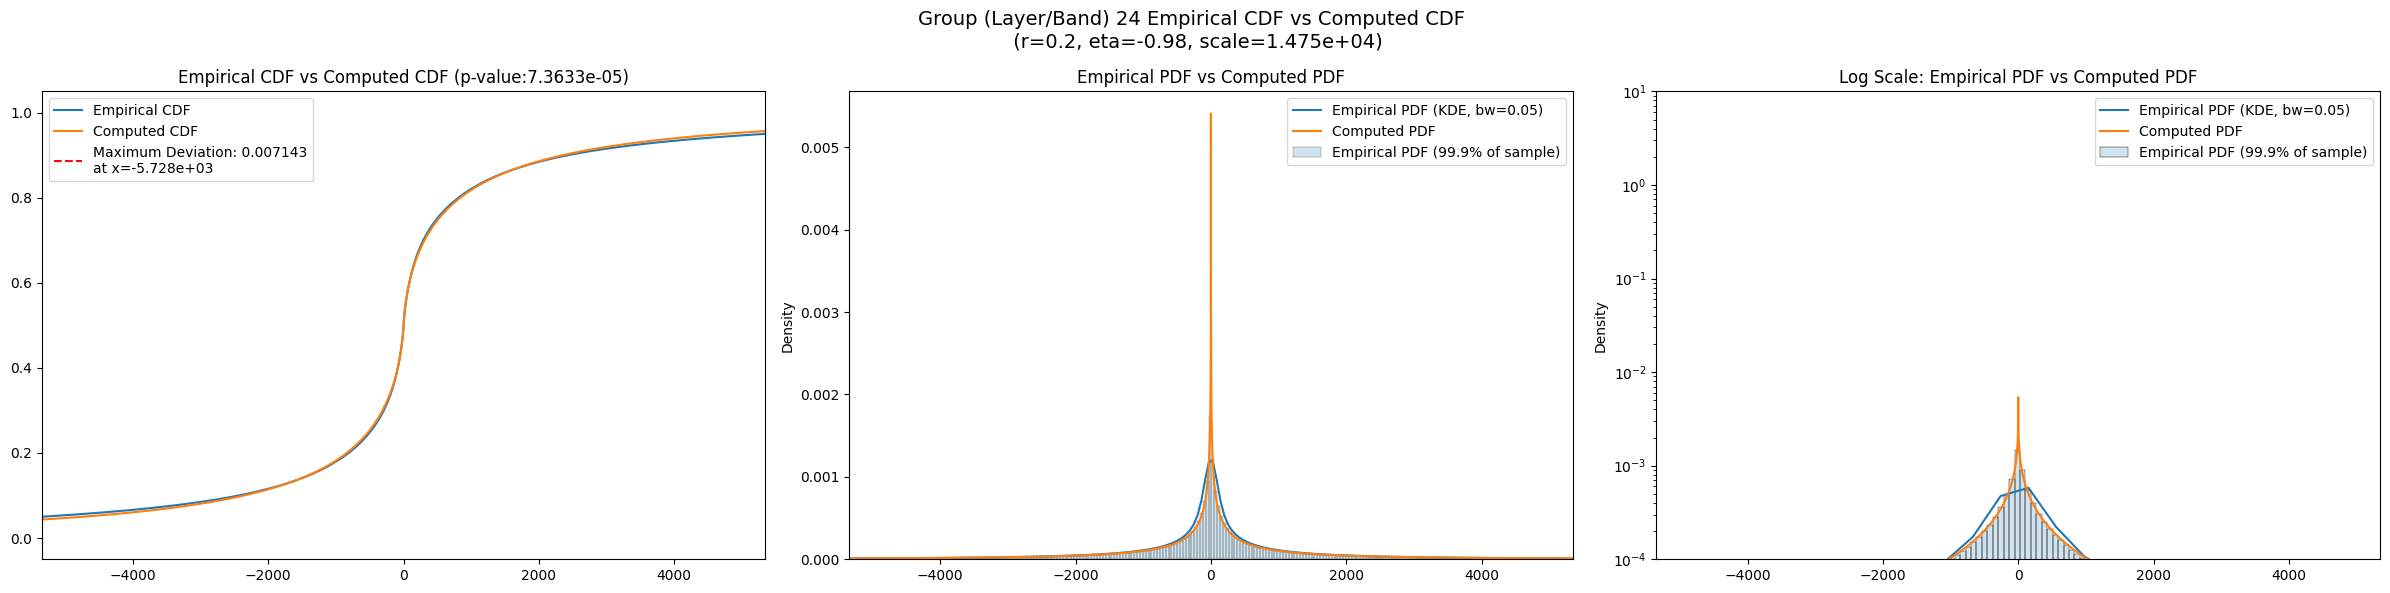

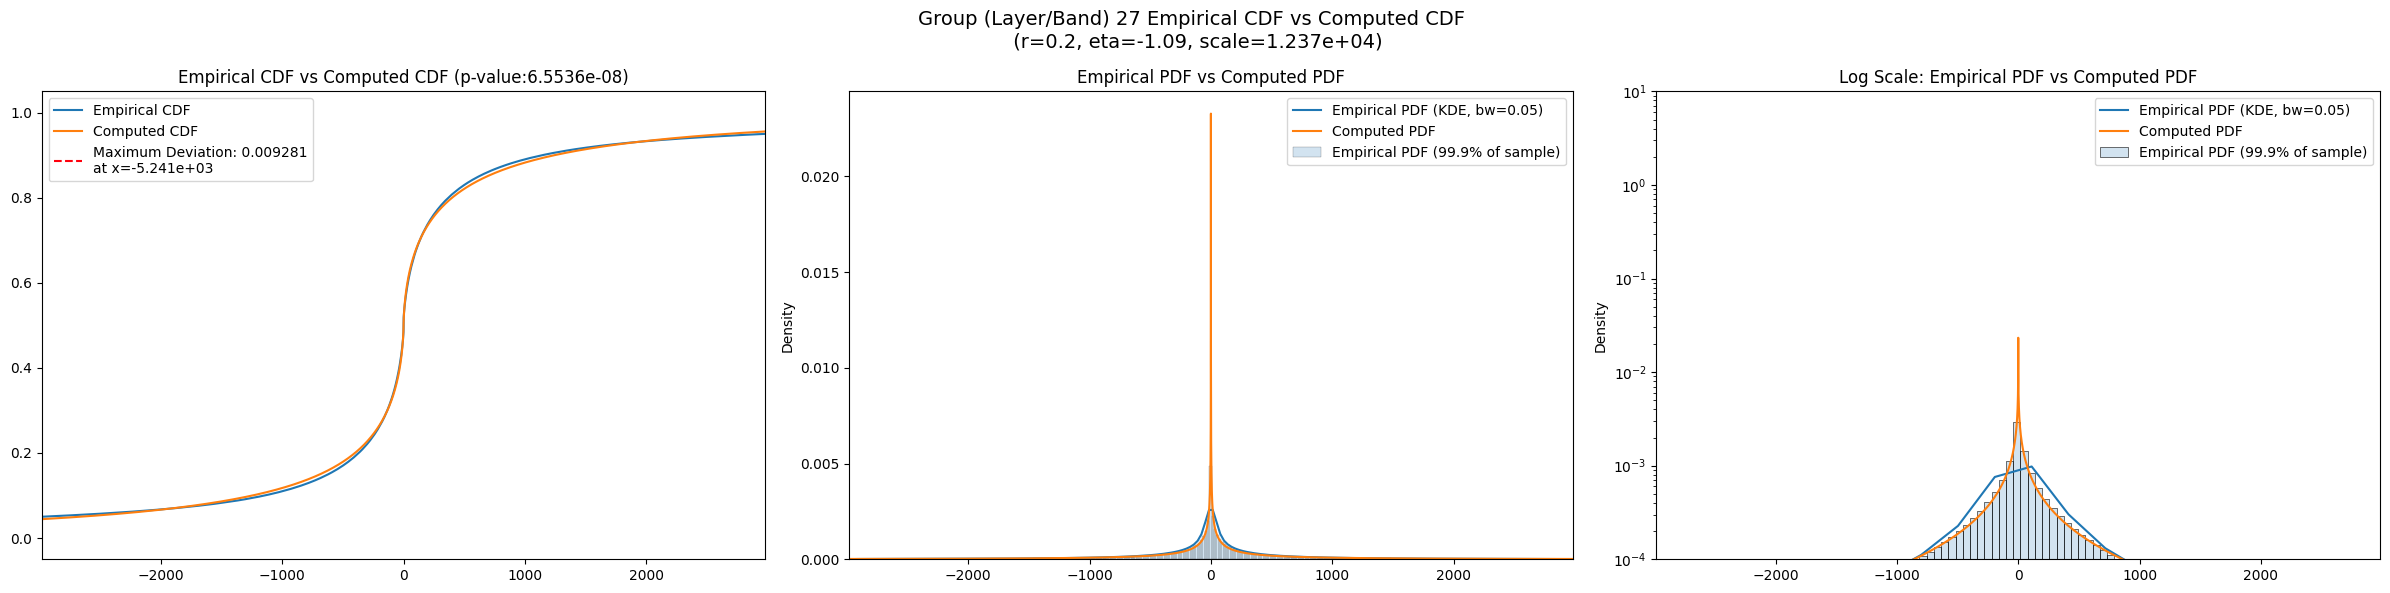

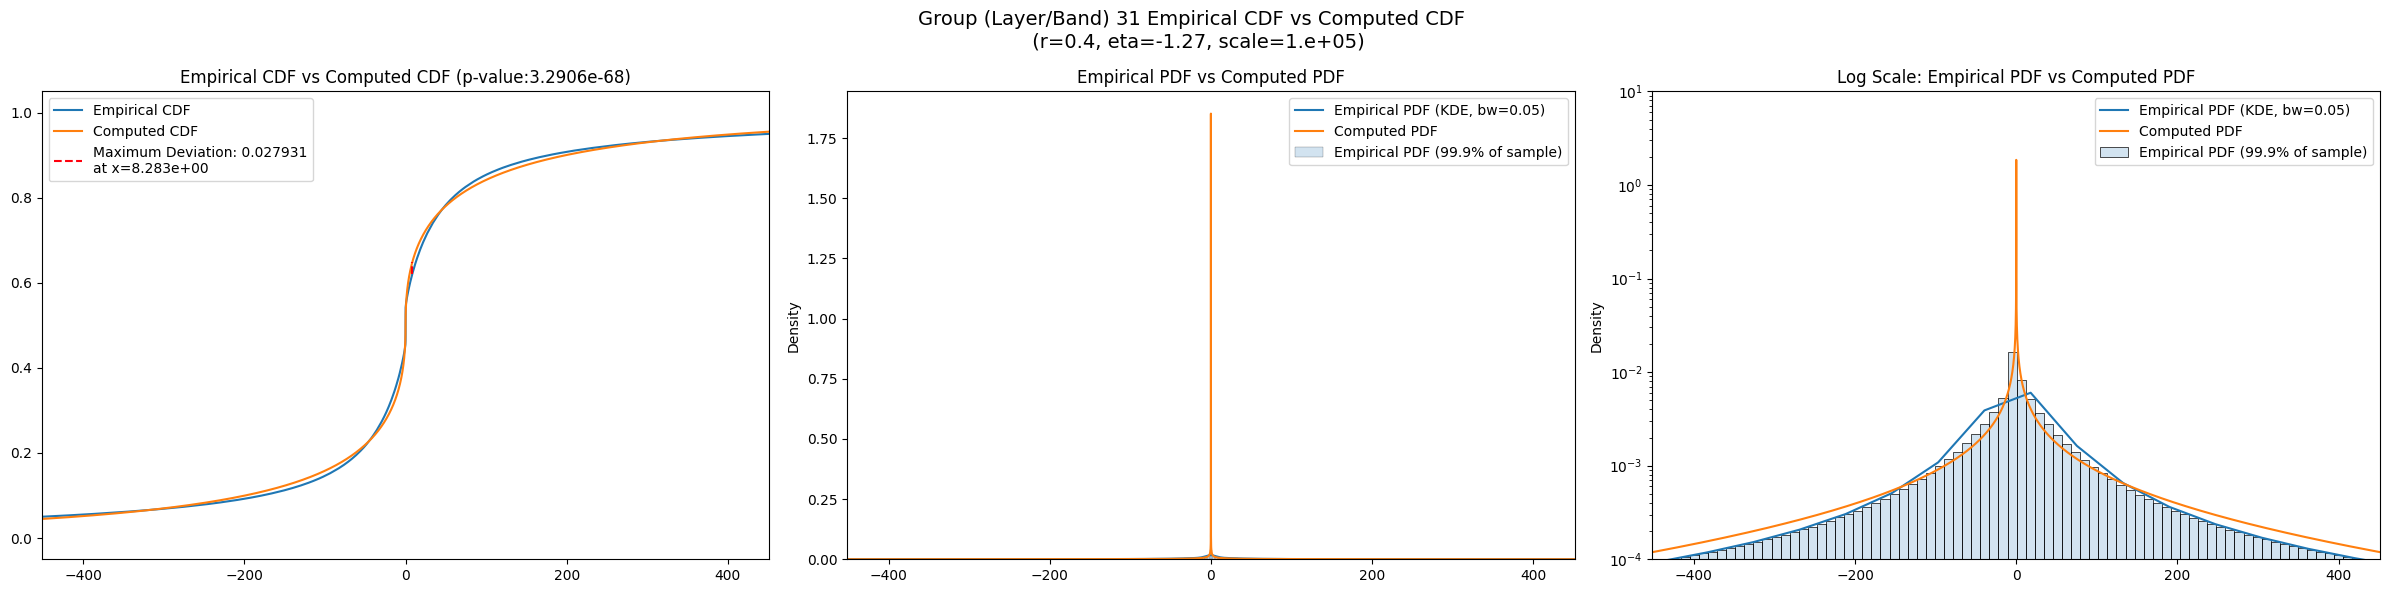

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304350e+08  8.450639e+08  1.021473e+09  11.475002    9.686062   
5     2.319913e+09  2.172740e+09  2.471595e+09   4.323010    3.781578   
8     1.712932e+09  1.609256e+09  1.820339e+09   3.816700    3.299652   
11    1.477210e+09  1.393562e+09  1.562147e+09   2.952862    2.647646   
14    3.512004e+08  3.220831e+08  3.815291e+08   8.838118    7.747682   
18    7.135070e+07  6.541452e+07  7.777086e+07   9.288547    7.105037   
21    2.806441e+07  2.528724e+07  3.112942e+07  14.143866   10.129042   
24    2.347062e+07  2.053493e+07  2.665636e+07  23.600979   19.822874   
27    1.144604e+07  9.863044e+06  1.315475e+07  29.179123   24.510862   
31    3.226470e+05  2.673852e+05  3.902298e+05  51.517807   34.074745   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.108884       100000.0             0.023541        0.1          0.0   
5       4.905125       100000.0             0.032234        0.2         -0.1   
8       4.357325       100000.0             0.023858        0.2          0.5   
11      3.273485       100000.0             0.030867        0.2          0.1   
14     10.001733       100000.0             0.017490        0.2         -0.5   
18     12.427702       100000.0             0.016070        0.2         -0.2   
21     20.413070       100000.0             0.014821        0.2         -0.5   
24     27.856232       100000.0             0.008048        0.2         -1.0   
27     34.519924       100000.0             0.009771        0.2         -1.1   
31    113.403180       100000.0             0.032289        0.2         -1.1   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       8542.6800              0.092258          0.000000e+00   
5     ...      26234.9000              0.075150          0.000000e+00   
8     ...      26246.0000              0.057208         6.442770e-285   
11    ...      22005.2000              0.074274          0.000000e+00   
14    ...       7798.7100              0.079009          0.000000e+00   
18    ...       4376.0100              0.066433          0.000000e+00   
21    ...       2340.2900              0.071224          0.000000e+00   
24    ...       1043.8700              0.090967          0.000000e+00   
27    ...        482.8350              0.091938          0.000000e+00   
31    ...         79.5565              0.087808          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2         7615.1300             0.068106         0.000000e+00   5764.7400   
5        22115.0000             0.051374        8.094020e-230  17646.0000   
8        22427.5000             0.032286         5.396340e-91  18246.7000   
11       18864.5000             0.048446        2.114620e-204  15046.0000   
14        6743.4700             0.052960        3.257570e-244   5273.4900   
18        3783.7600             0.040178        1.060480e-140   2970.9200   
21        2018.2600             0.045674        1.005890e-181   1573.0200   
24         908.8530             0.067062         0.000000e+00    686.9610   
27         422.4000             0.069014         0.000000e+00    314.6080   
31          69.8958             0.065401         0.000000e+00     51.3454   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.064789   0.000000e+00          4.863503e-41  
5          0.055101  2.490340e-264          1.060155e-87  
8          0.037372  8.746670e-122          3.035347e-47  
11         0.051634  3.762710e-232          8.203444e-80  
14         0.0541

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.023541                 0.004293          0.021621   
5                0.032234                 0.004293          0.031693   
8                0.023858                 0.004293          0.023214   
11               0.030867                 0.004293          0.030227   
14               0.017490                 0.004293          0.017062   
18               0.016070                 0.004293          0.015056   
21               0.014821                 0.004293          0.011327   
24               0.008048                 0.004293          0.007143   
27               0.009771                 0.004293          0.009623   
31               0.032289                 0.004293          0.028315   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.092258             0.068106       0.064789  
5                 0.075150             0.051374       0.055101  
8                 0.057208             0.032286       0.037372  
11                0.074274             0.048446       0.051634  
14                0.079009             0.052960       0.054119  
18                0.066433             0.040178       0.041972  
21                0.071224             0.045674       0.047012  
24                0.090967             0.067062       0.065832  
27                0.091938             0.069014       0.067093  
31                0.087808             0.065401       0.063409

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           9.304350e+08          0.021621    0.13     -0.40       6.042347   
5           2.319913e+09          0.031693    0.20     -0.13   45614.421938   
8           1.666046e+09          0.023214    0.22      0.30   50324.220540   
11          1.462489e+09          0.030227    0.21      0.00   43550.844790   
14          3.512004e+08          0.017062    0.20     -0.51   24113.366600   
18          7.135070e+07          0.015056    0.25     -0.50   84941.304762   
21          2.806441e+07          0.011327    0.25     -0.70   64768.163624   
24          2.347062e+07          0.007143    0.20     -0.98   14748.877079   
27          9.571533e+06          0.009623    0.20     -1.09   12371.604407   
31          1.526414e+05          0.028315    0.40     -1.27  100000.000000   

      best_exclude_cutoff  
band                       
2                     0.0  
5                     0.0  
8                    50.0  
11                   25.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                    0.0  
27                  100.0  
31                  450.0